## In this tutorial, I will show how to code a license plate recognizer for Indian license plates using deep learning and some image processing.
### Find the detailed explanation of the project in this blog: https://towardsdatascience.com/ai-based-indian-license-plate-detector-de9d48ca8951?source=friends_link&sk=a2cbd70e630f6dc3d030e3bae34d98ef

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [252]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [253]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

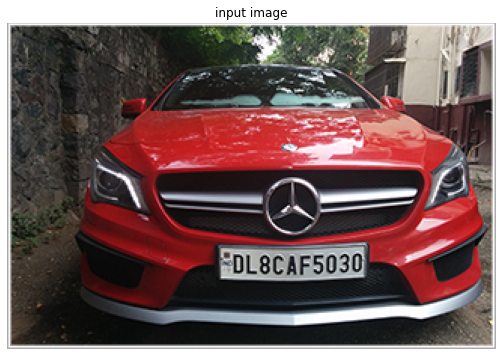

In [254]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('car.jpg')
display(img, 'input image')

In [255]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

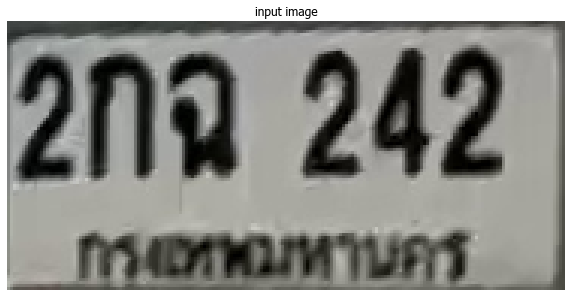

In [464]:
plate = cv2.imread('plate/1_80_per.png')
#print(plate)
display(plate, 'input image')

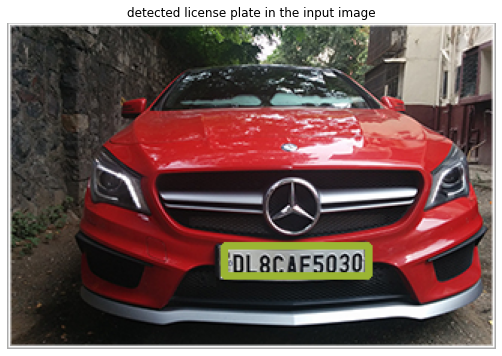

In [257]:
#display(output_img, 'detected license plate in the input image')

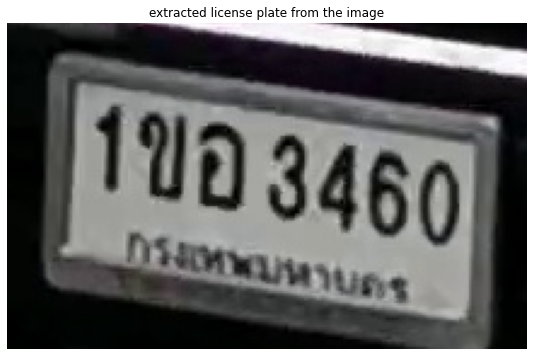

In [197]:
display(plate, 'extracted license plate from the image')

In [477]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:24]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        #print(intX, intY, intWidth, intHeight)
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours
            #print(x_cntr_list)
            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            #print(cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2))
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

(89, 159, 3)


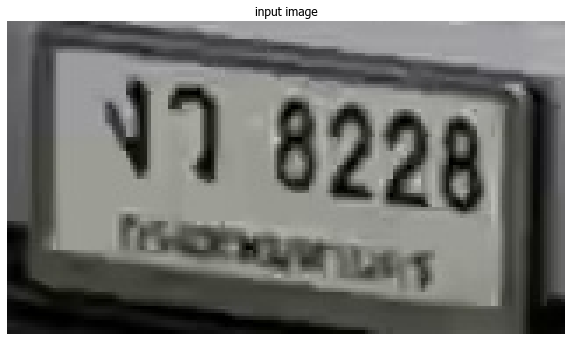

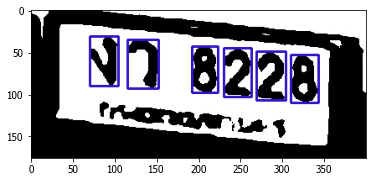

In [585]:
plate = cv2.imread('plate/1_3.png')
print(plate.shape)
#print(plate)
display(plate, 'input image')
# Let's see the segmented characters
char = segment_characters(plate)

In [514]:
from random import randrange
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (400, 176))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (4,4))
    #img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    #img_binary_lp = cv2.dilate(img_binary_lp, (10,10))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    #img_binary_lp[0:3,:] = 255
    #img_binary_lp[:,0:3] = 255
    #img_binary_lp[0:80,:] = 255
    #img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/(12),
                       LP_WIDTH/(2),
                       LP_HEIGHT/(10),
                       2*LP_HEIGHT/(3)]
    #print(dimensions)
    #plt.imshow(img_binary_lp, cmap='gray')
    #plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
        
    

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
#     if len(char_list)>=8:
#         print("------------------------------")
#         print("Hello")
#         print(len(char_list))
        
#         print(a,b,c,d)
        
#         print(dimensions)
#         print("------------------------------")
    #print(dimensions)
    #print(img_binary_lp)
    

    return char_list

In [285]:
 import os
 arr = os.listdir('plate/')
 print(arr)

['1826.jpg', '1_1.png', '1_10.png', '1_11.png', '1_12.png', '1_13.png', '1_14.png', '1_15.png', '1_16.png', '1_17.png', '1_18.png', '1_19.png', '1_2.png', '1_20.png', '1_21.png', '1_22.png', '1_23.png', '1_24.png', '1_25.png', '1_26.png', '1_27.png', '1_28.png', '1_29.png', '1_30.png', '1_31.png', '1_32.png', '1_33.png', '1_34.png', '1_35.png', '1_36.png', '1_37.png', '1_38.png', '1_39.png', '1_4.png', '1_40.png', '1_41.png', '1_42.png', '1_43.png', '1_44.png', '1_45.png', '1_46.png', '1_47.png', '1_48.png', '1_49.png', '1_5.png', '1_50.png', '1_51.png', '1_52.png', '1_53.png', '1_54.png', '1_55.png', '1_56.png', '1_57.png', '1_58.png', '1_59.png', '1_6.png', '1_60.png', '1_61.png', '1_62.png', '1_63.png', '1_64.png', '1_65.png', '1_66.png', '1_67.png', '1_68.png', '1_69.png', '1_7.png', '1_70.png', '1_71.png', '1_72.png', '1_73.png', '1_74.png', '1_75.png', '1_76.png', '1_77.png', '1_78.png', '1_79.png', '1_8.png', '1_80.png', '1_80_per.png', '1_81.png', '1_82.png', '1_83.png', '1_84.

In [357]:
n= 0

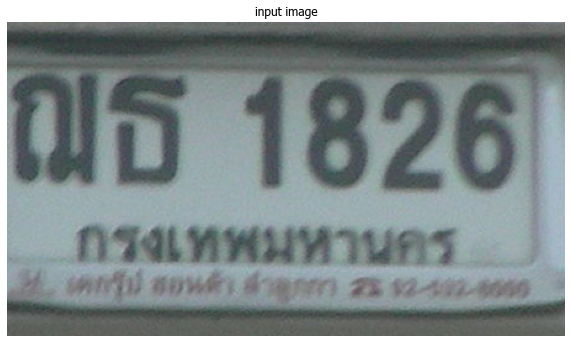

(255, 453, 3)


<ipython-input-596-2afac61942ed>:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if char != []:


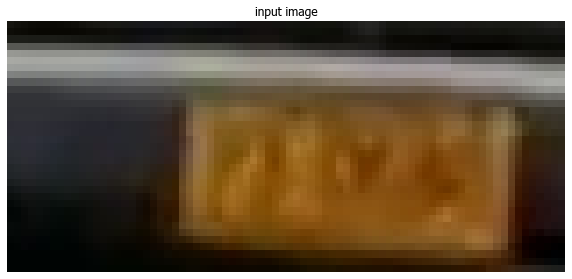

(35, 78, 3)


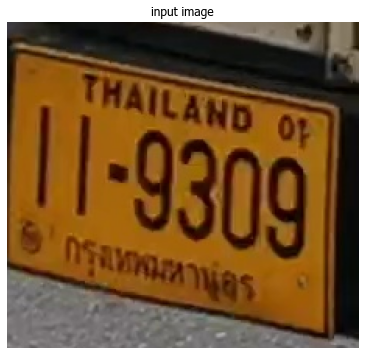

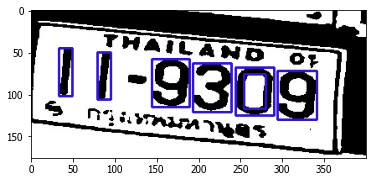

(210, 226, 3)


<ipython-input-596-2afac61942ed>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if char != []:


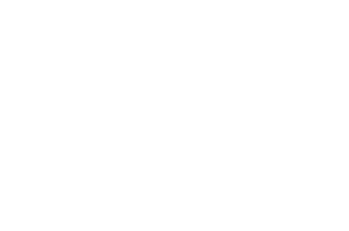

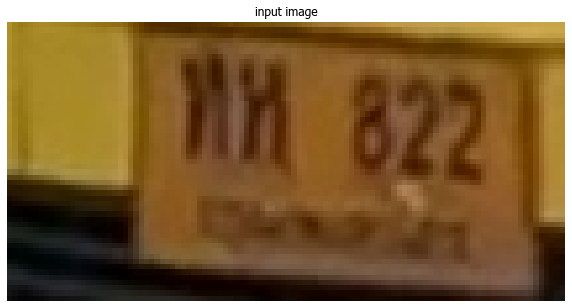

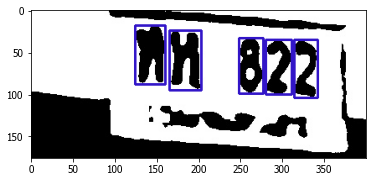

(53, 106, 3)


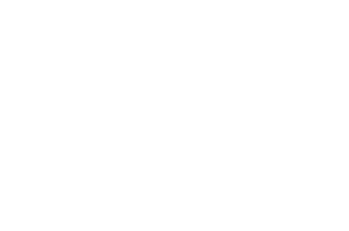

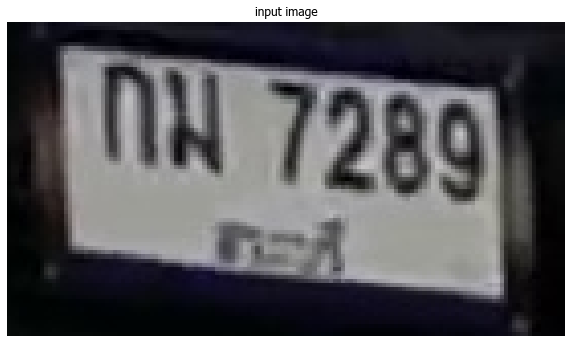

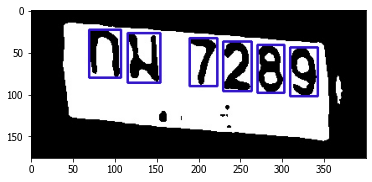

(77, 137, 3)


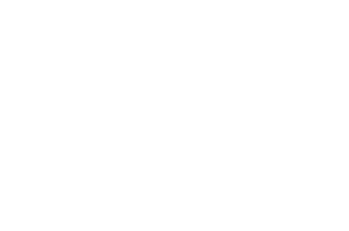

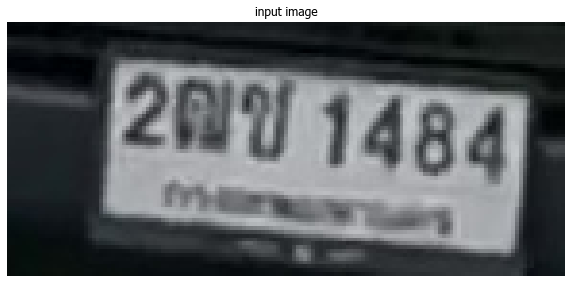

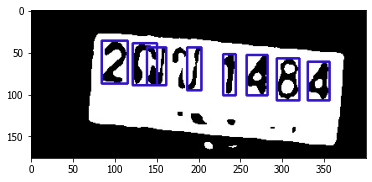

(66, 145, 3)


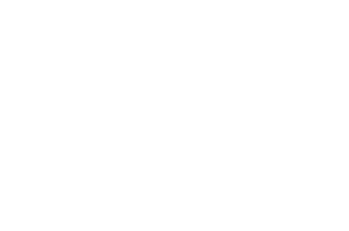

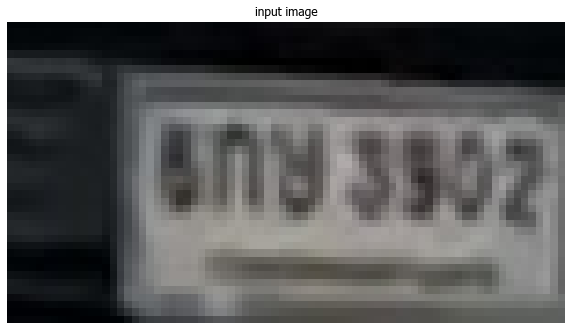

(41, 76, 3)


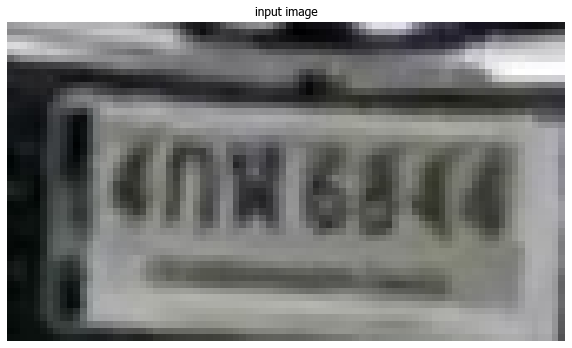

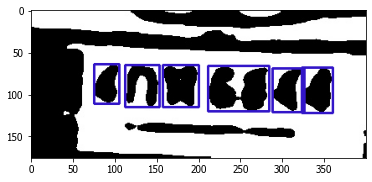

(48, 84, 3)


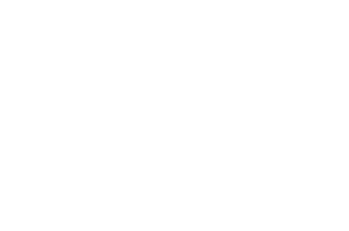

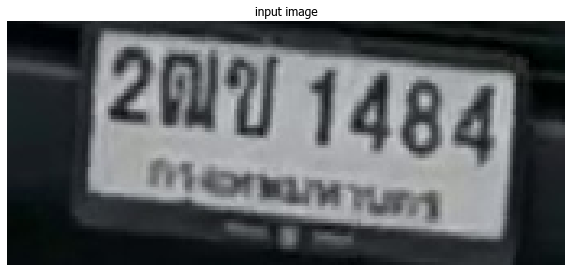

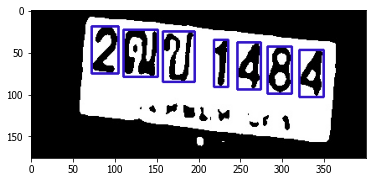

(75, 172, 3)


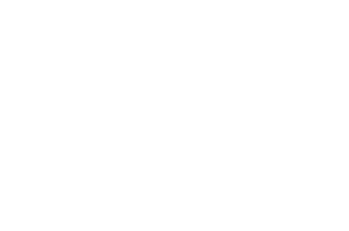

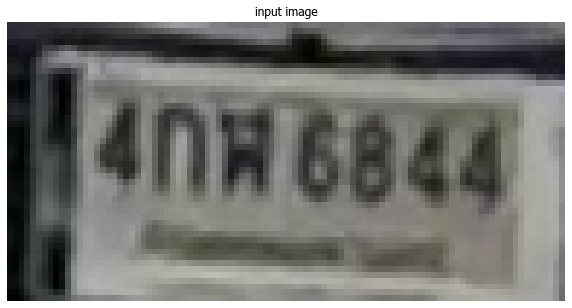

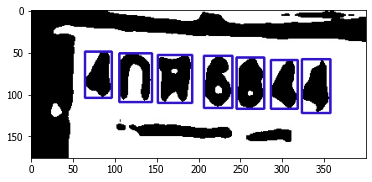

(48, 96, 3)


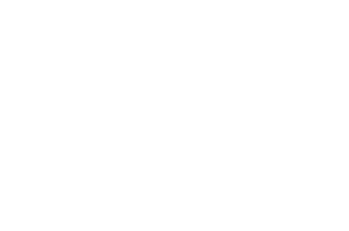

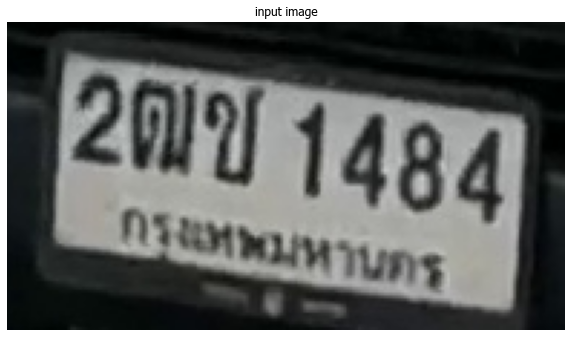

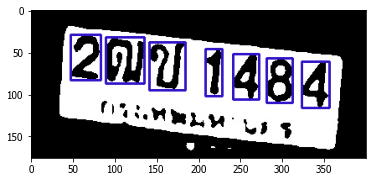

(107, 194, 3)


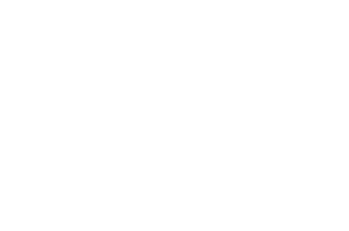

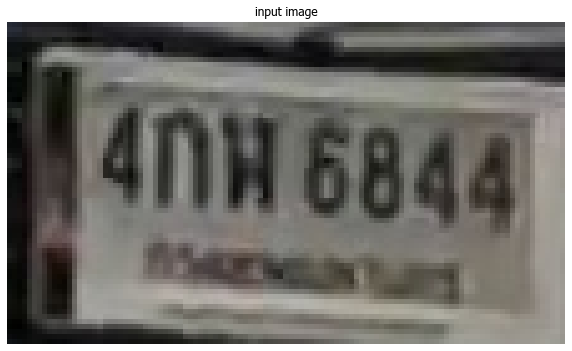

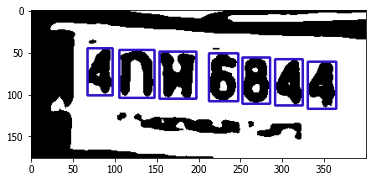

(64, 111, 3)


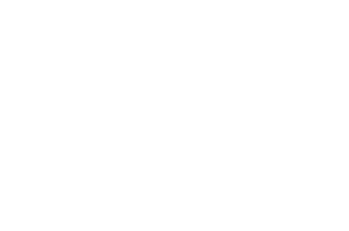

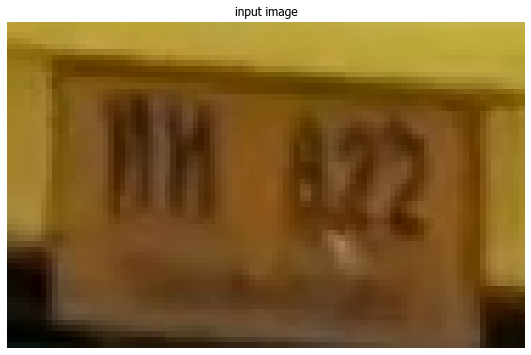

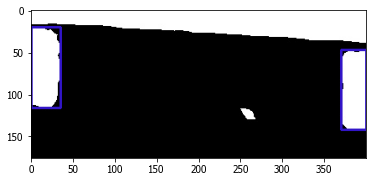

(58, 92, 3)


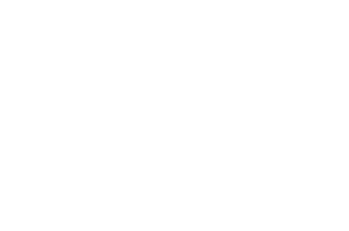

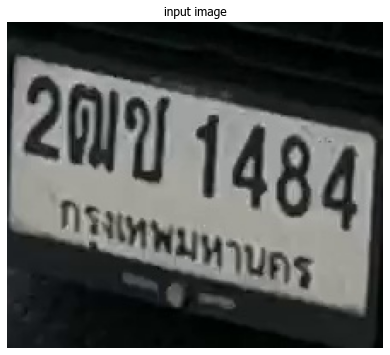

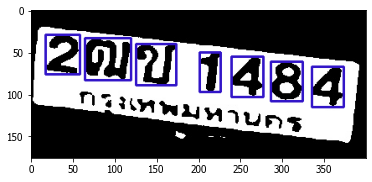

(191, 220, 3)


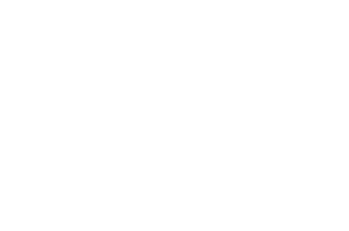

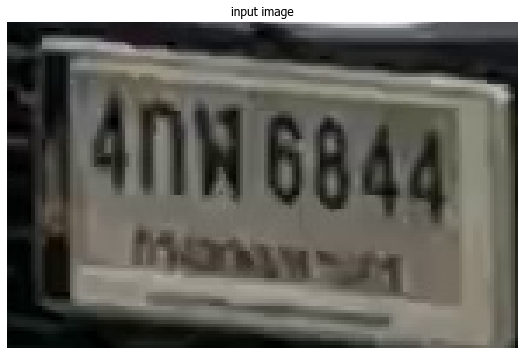

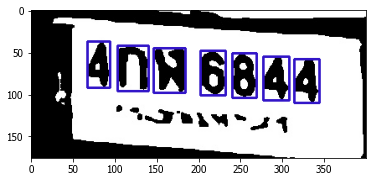

(94, 147, 3)


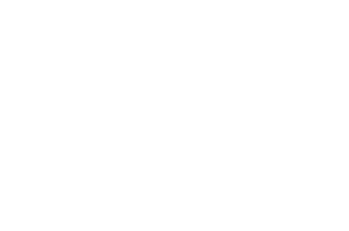

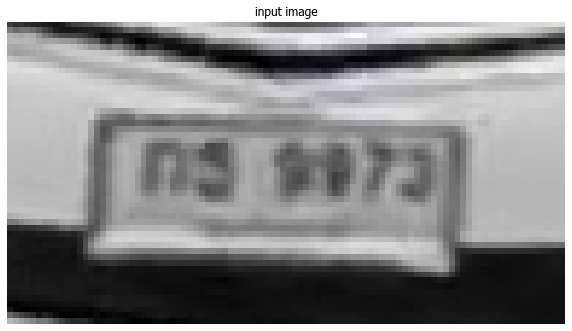

(52, 96, 3)


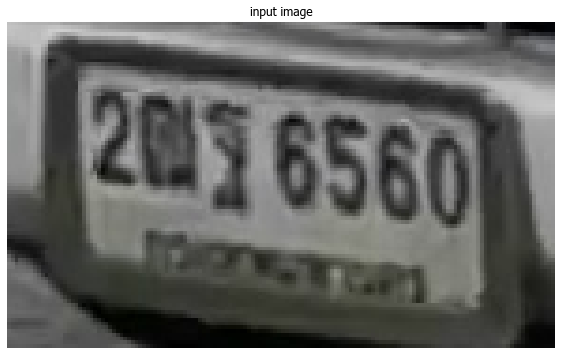

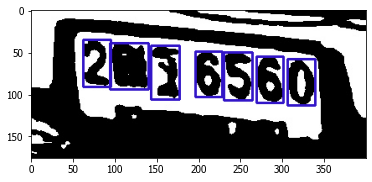

(87, 146, 3)


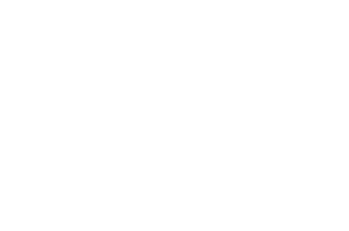

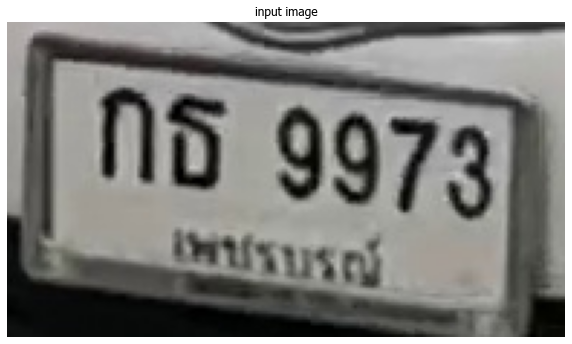

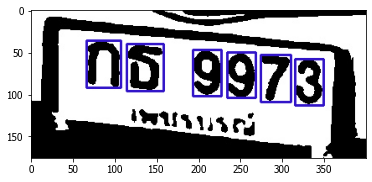

(109, 193, 3)


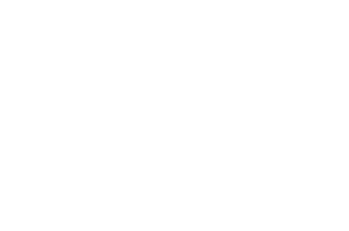

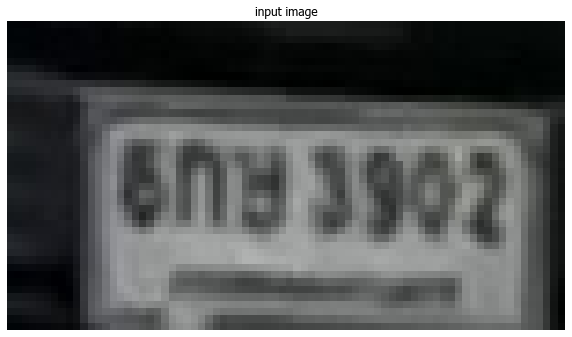

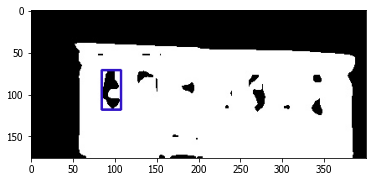

(42, 76, 3)


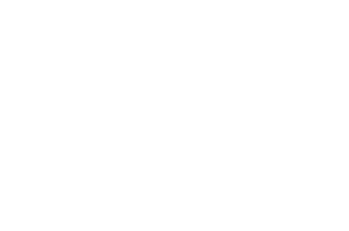

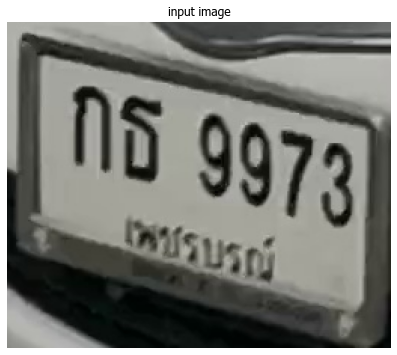

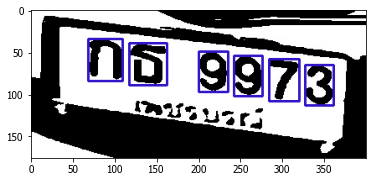

(217, 255, 3)


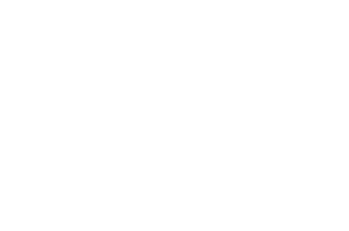

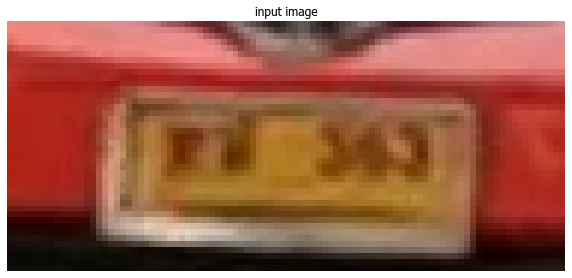

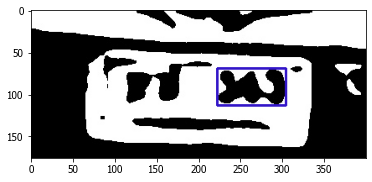

(42, 94, 3)


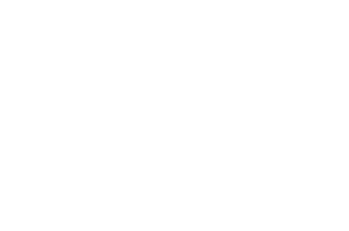

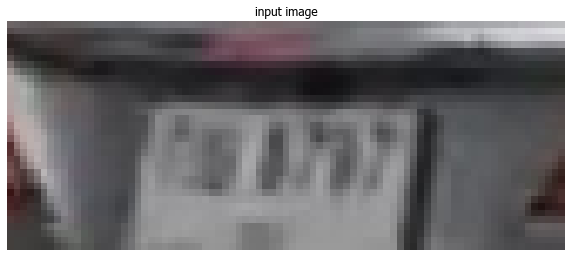

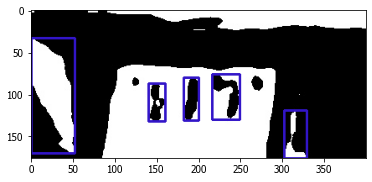

(34, 83, 3)


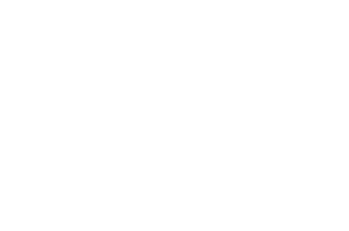

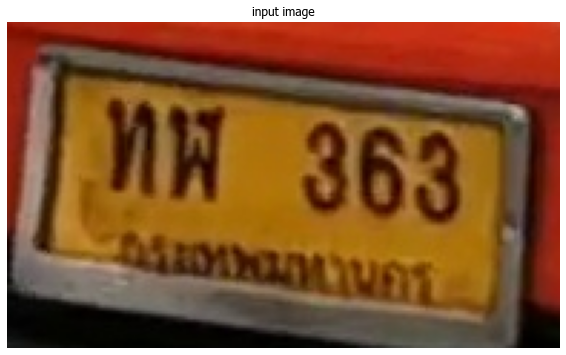

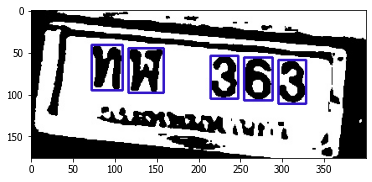

(114, 193, 3)


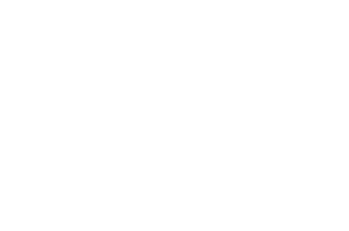

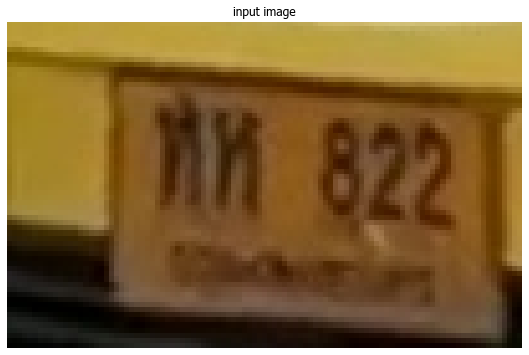

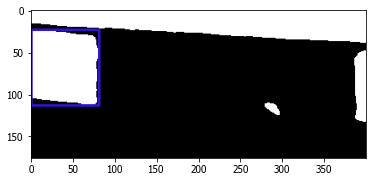

(64, 101, 3)


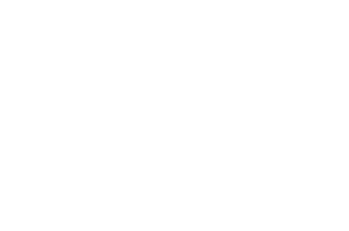

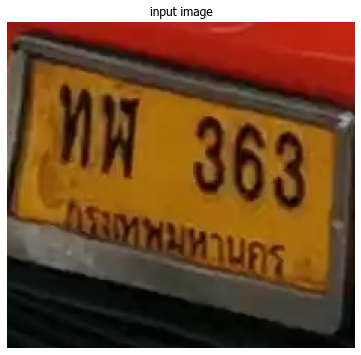

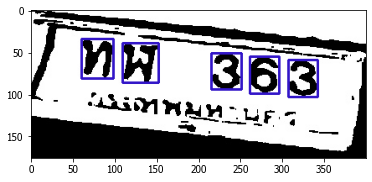

(216, 230, 3)


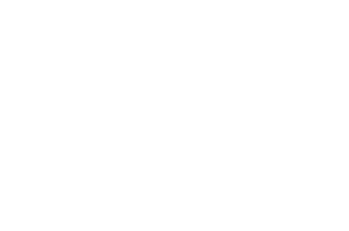

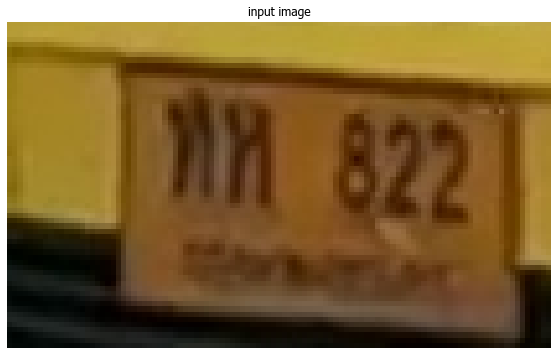

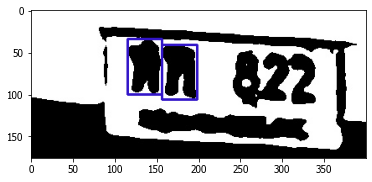

(63, 105, 3)


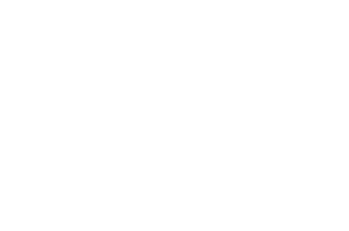

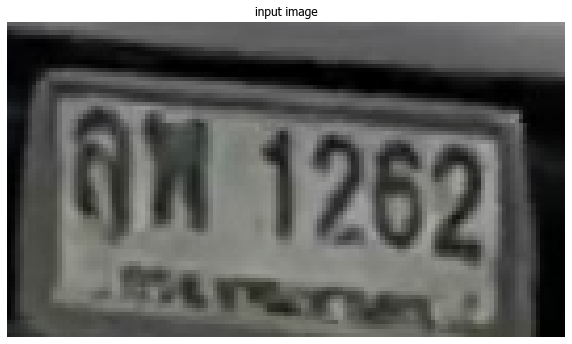

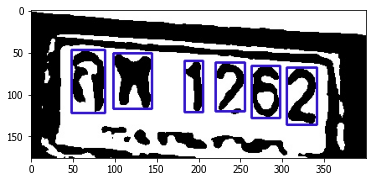

(75, 133, 3)


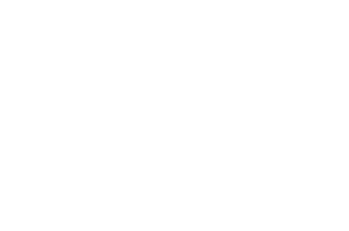

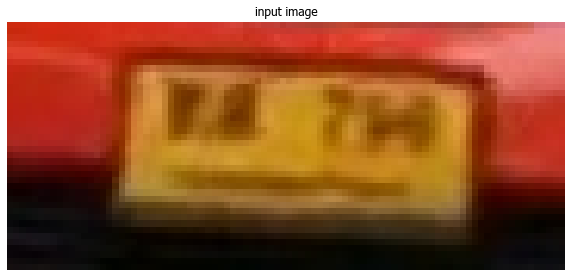

(40, 90, 3)


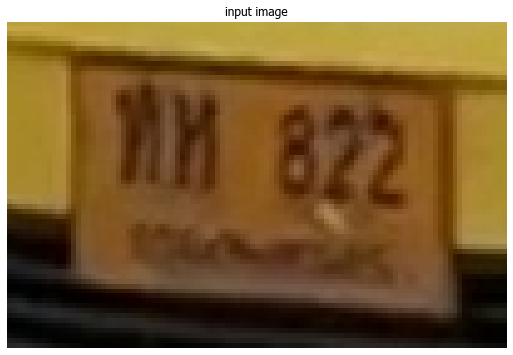

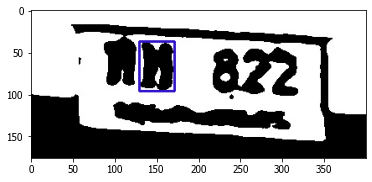

(66, 101, 3)


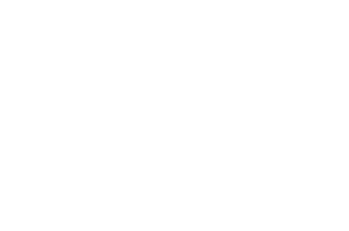

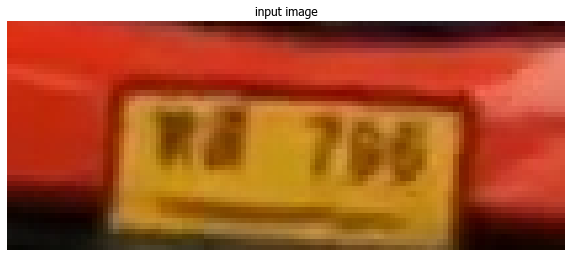

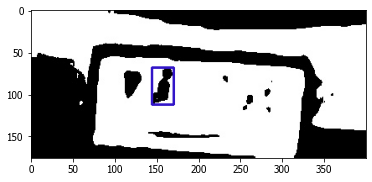

(43, 105, 3)


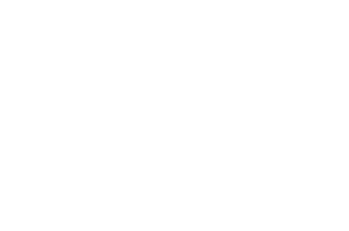

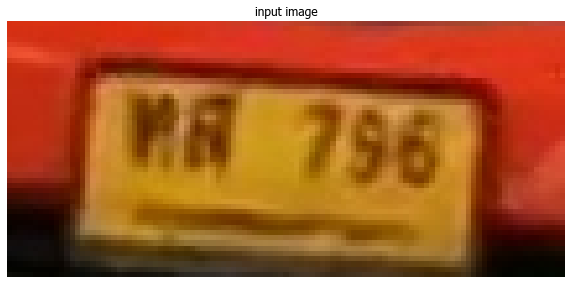

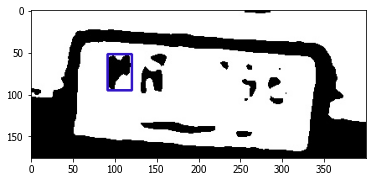

(49, 107, 3)


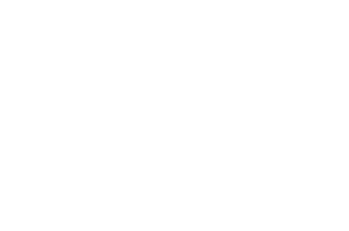

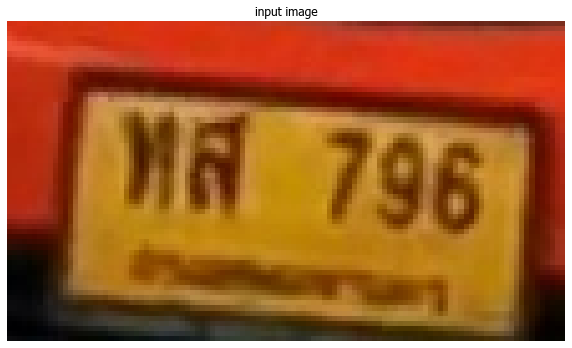

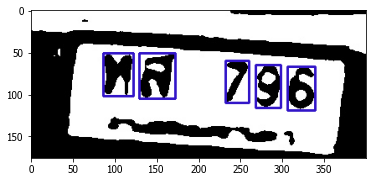

(63, 110, 3)


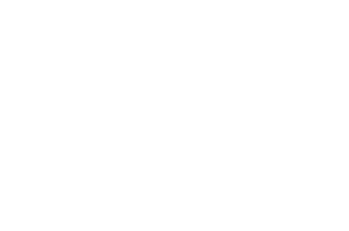

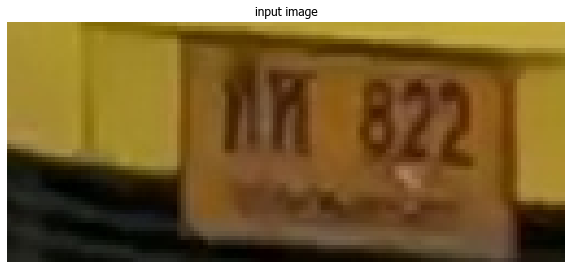

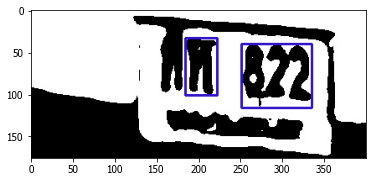

(55, 128, 3)


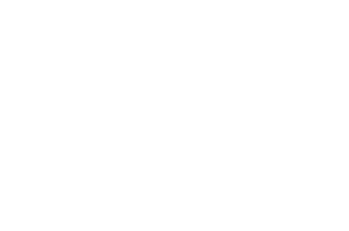

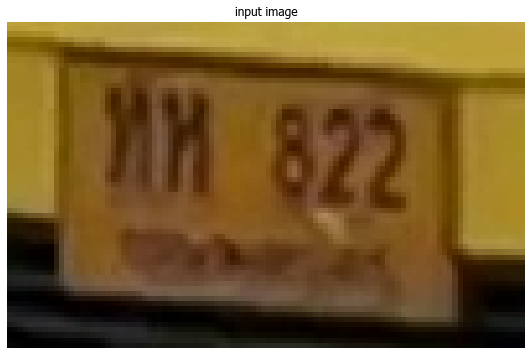

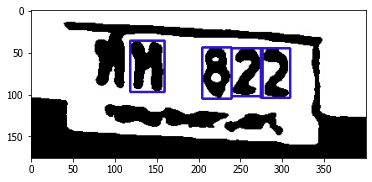

(63, 100, 3)


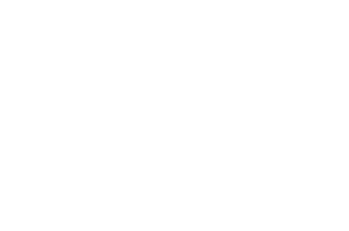

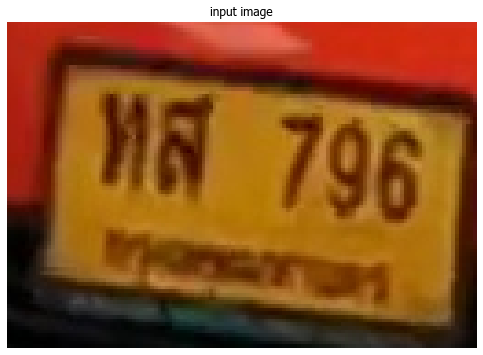

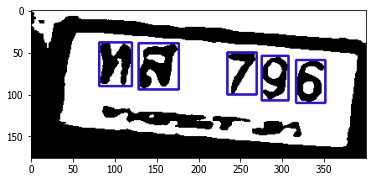

(89, 128, 3)


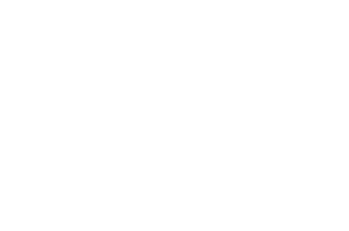

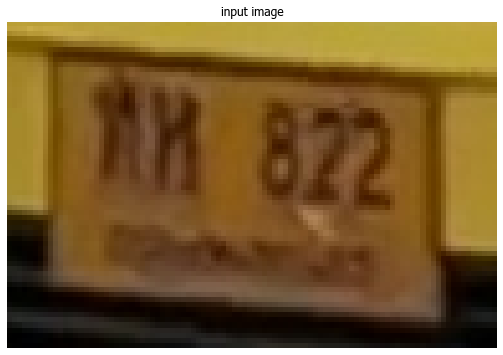

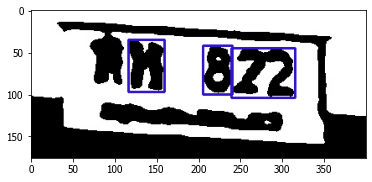

(64, 96, 3)


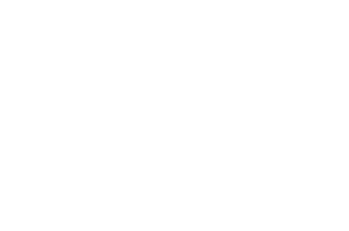

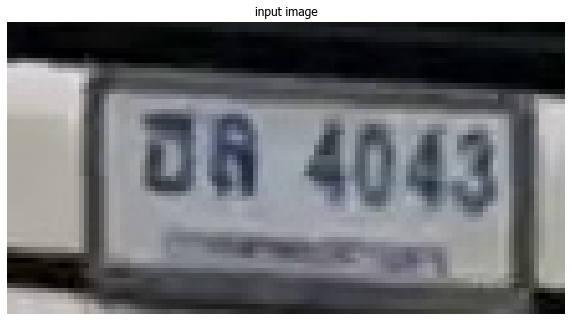

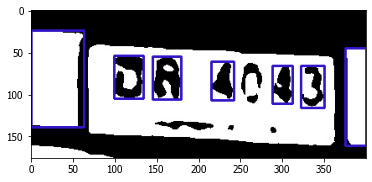

(57, 109, 3)


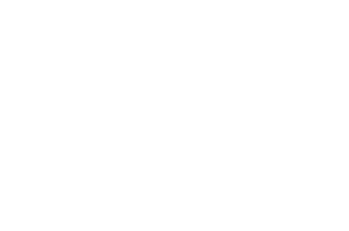

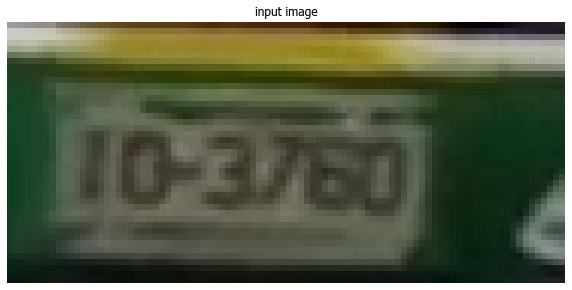

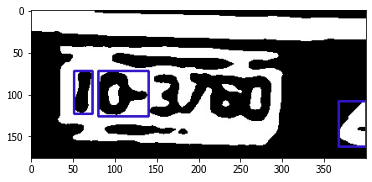

(43, 92, 3)


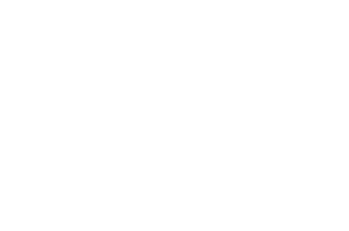

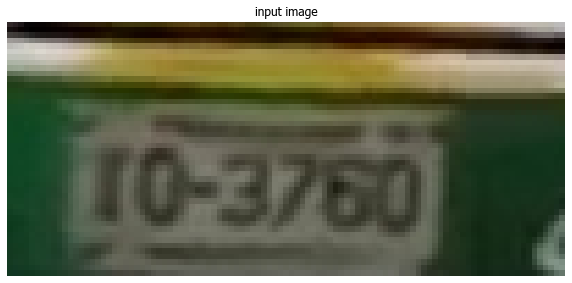

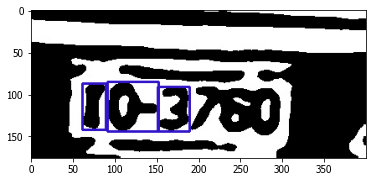

(46, 101, 3)


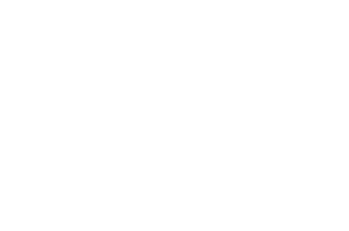

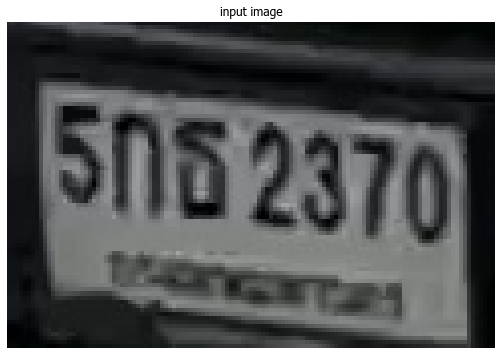

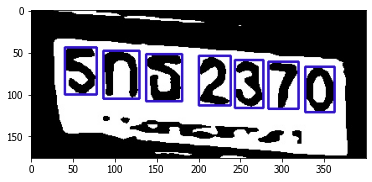

(81, 121, 3)


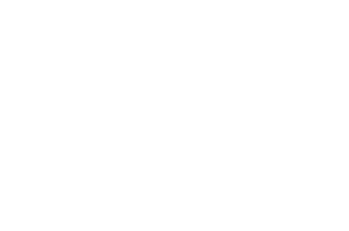

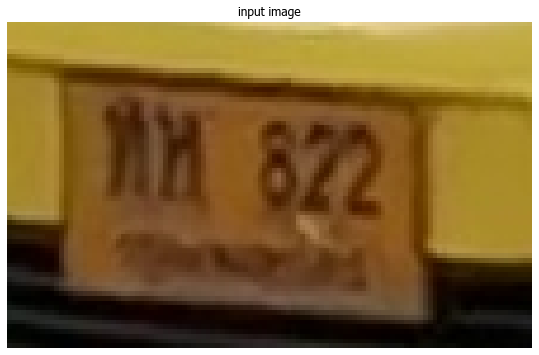

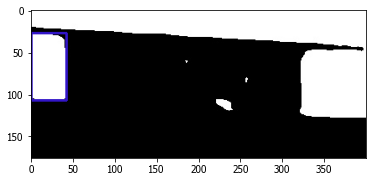

(69, 111, 3)


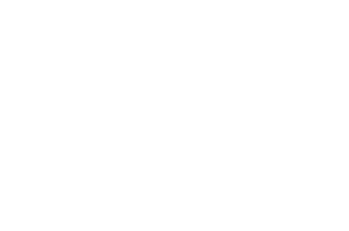

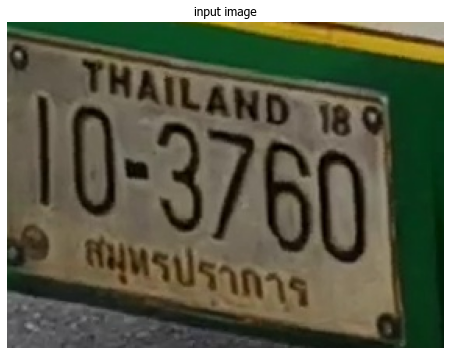

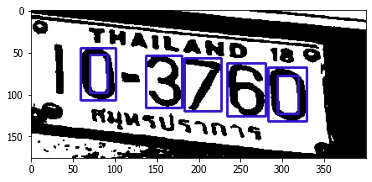

(209, 280, 3)


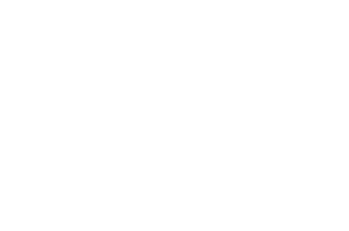

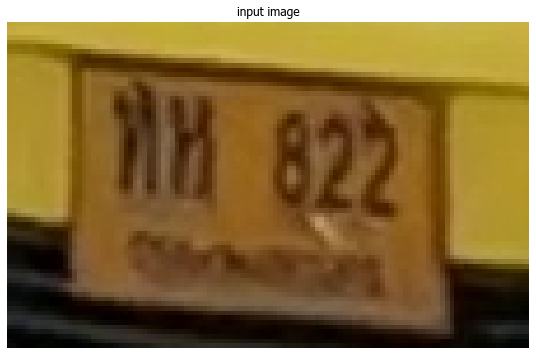

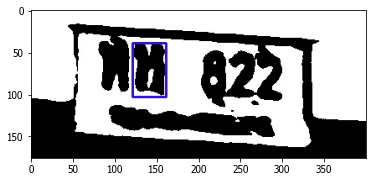

(70, 112, 3)


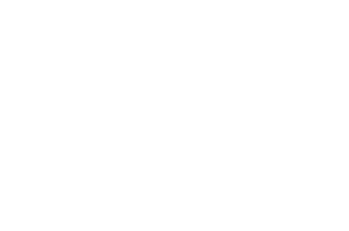

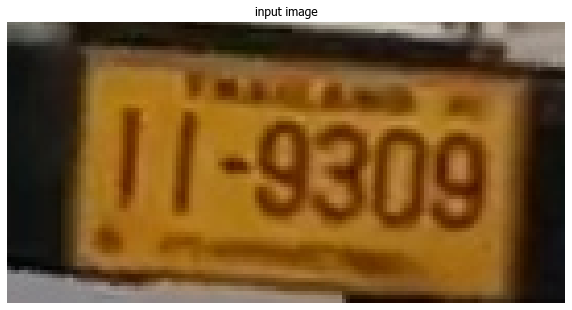

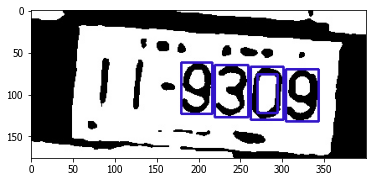

(68, 135, 3)


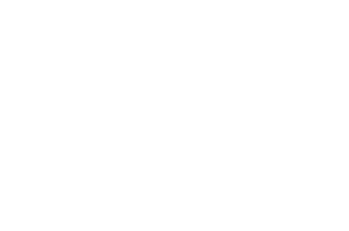

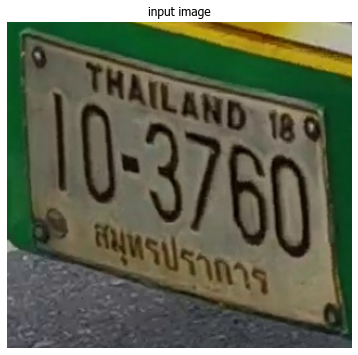

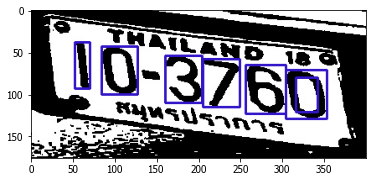

(301, 318, 3)


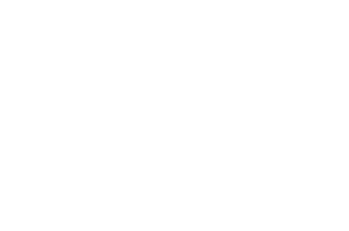

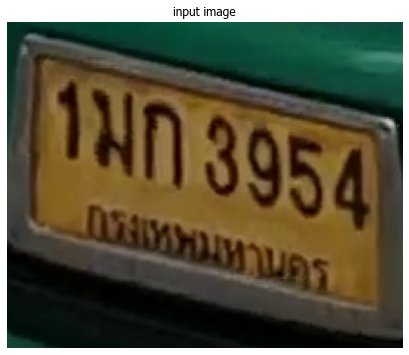

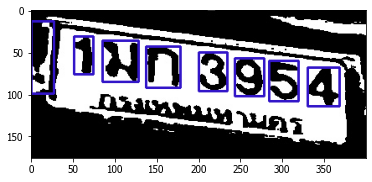

(180, 218, 3)


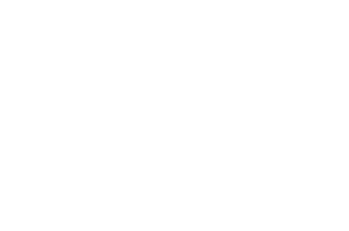

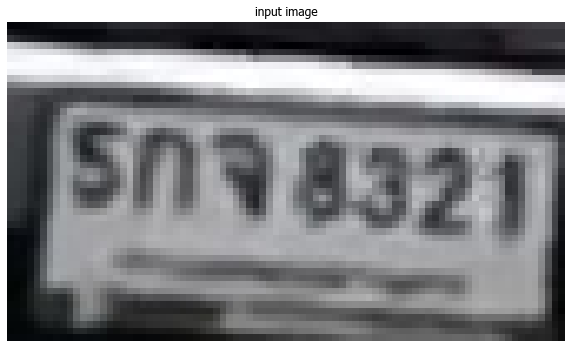

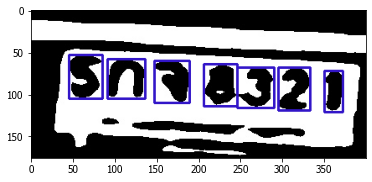

(48, 84, 3)


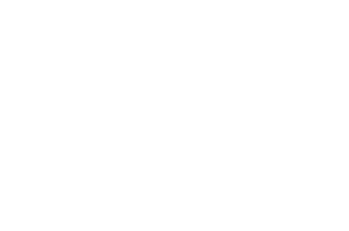

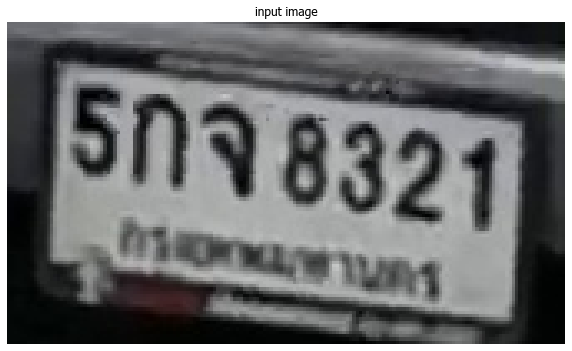

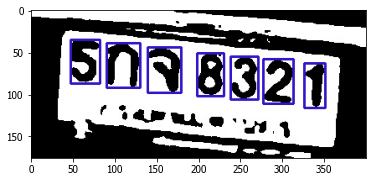

(97, 168, 3)


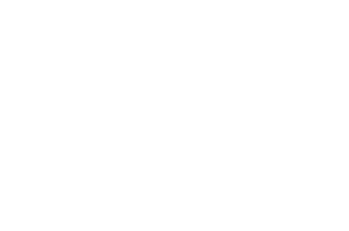

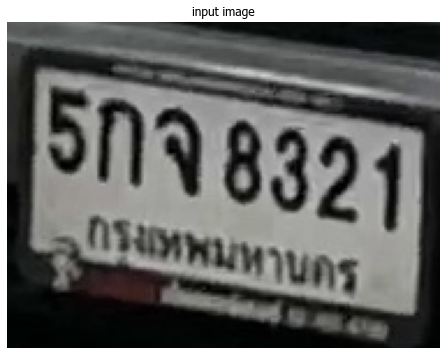

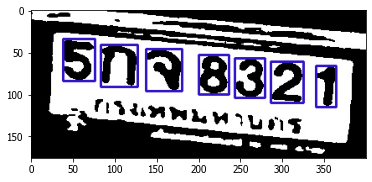

(141, 187, 3)


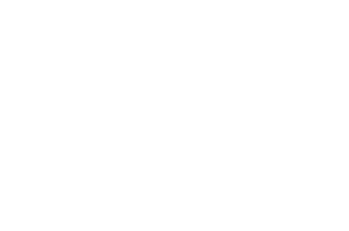

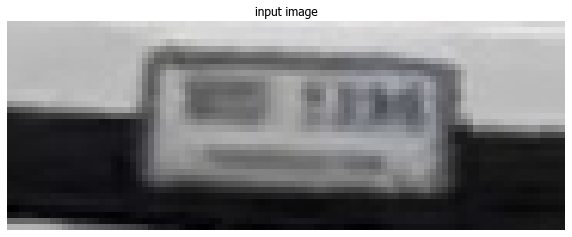

(34, 91, 3)


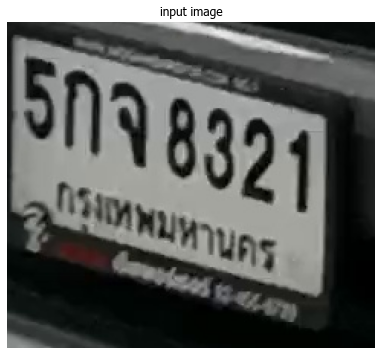

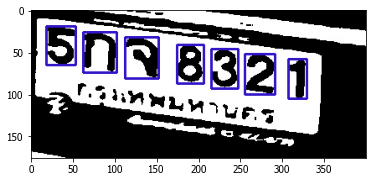

(214, 241, 3)


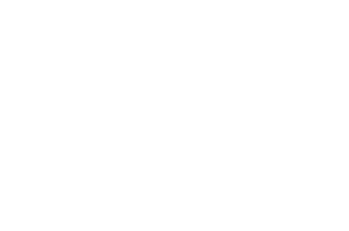

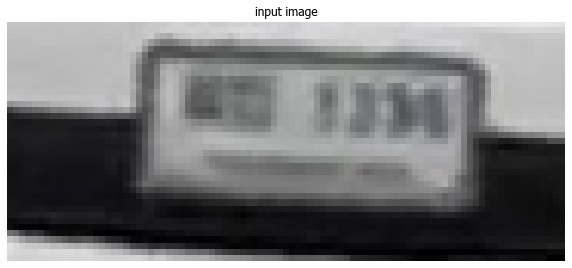

(39, 91, 3)


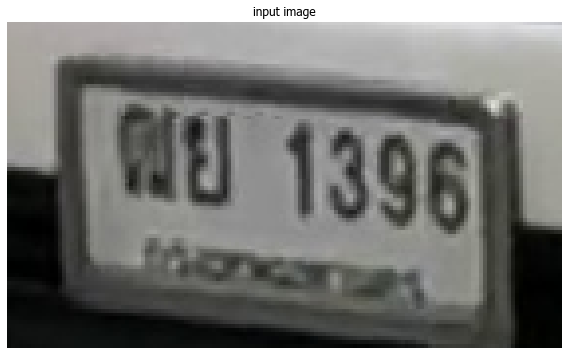

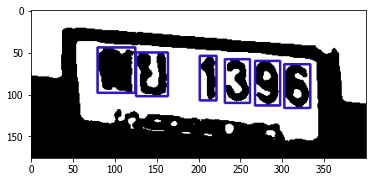

(83, 141, 3)


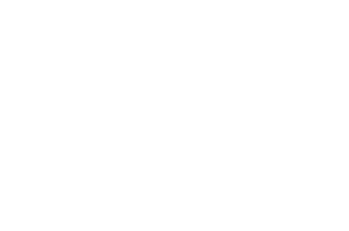

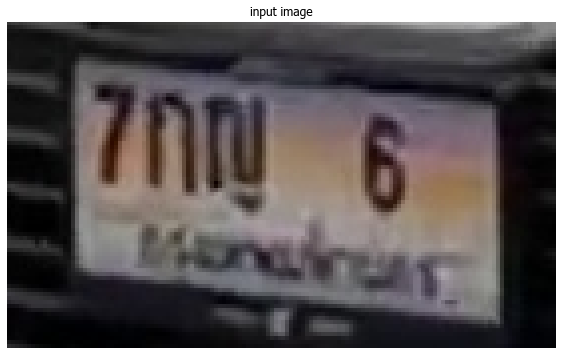

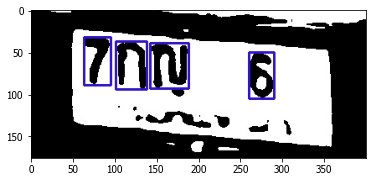

(82, 138, 3)


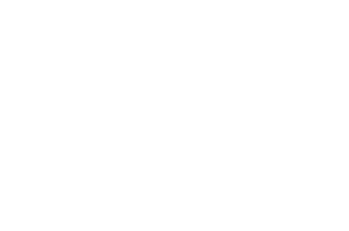

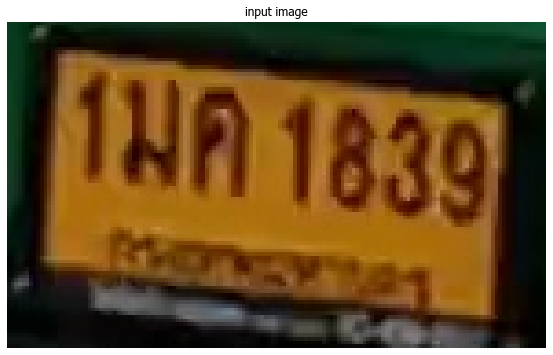

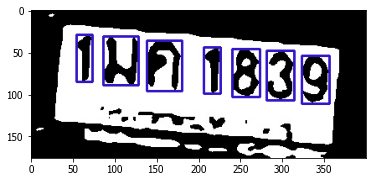

(89, 147, 3)


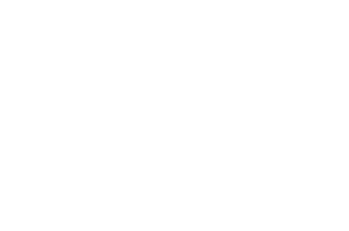

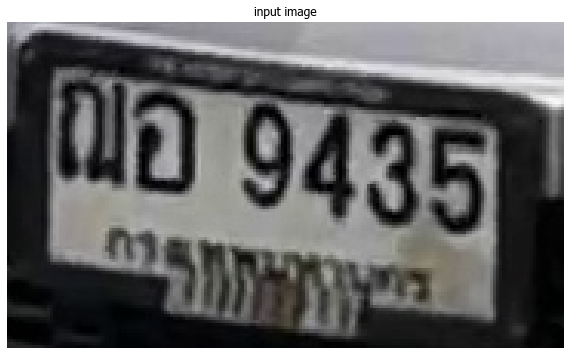

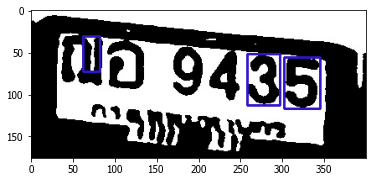

(106, 181, 3)


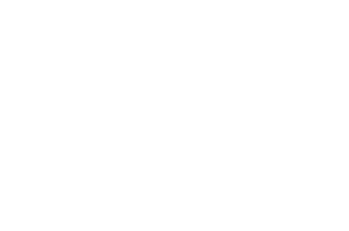

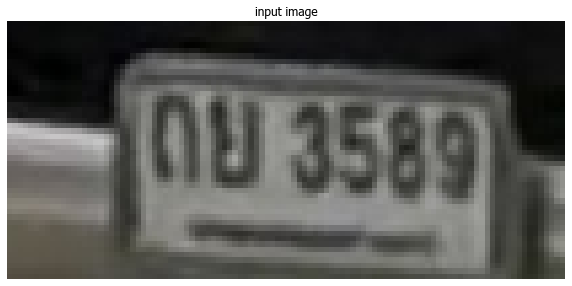

(48, 104, 3)


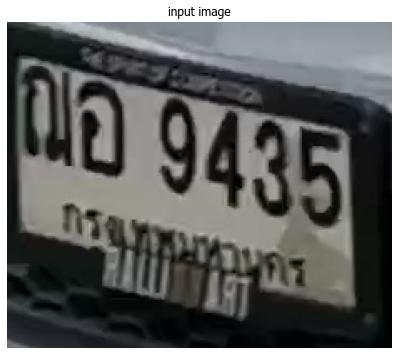

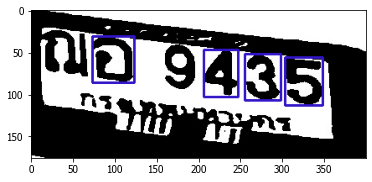

(196, 231, 3)


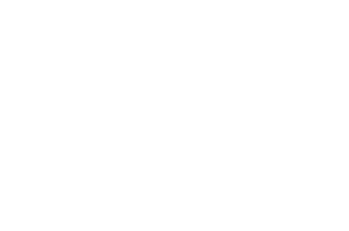

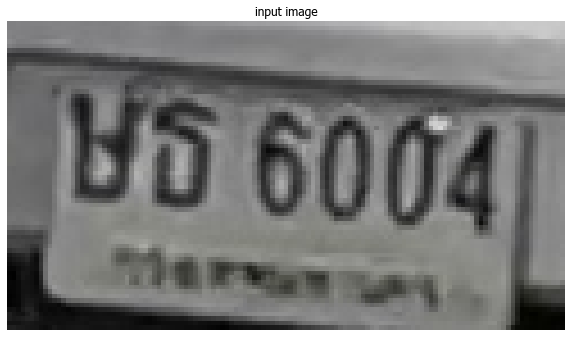

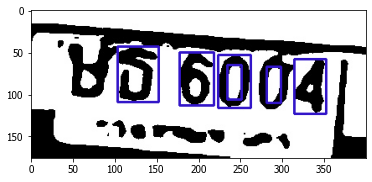

(68, 123, 3)


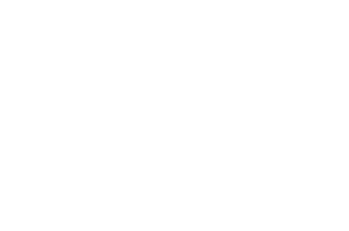

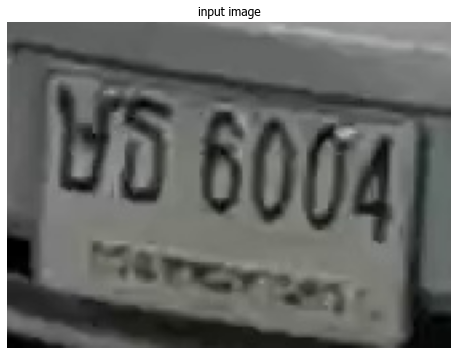

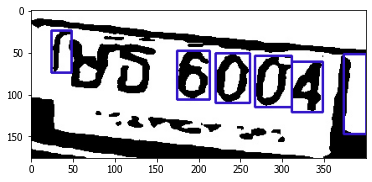

(122, 166, 3)


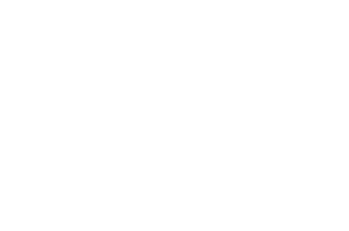

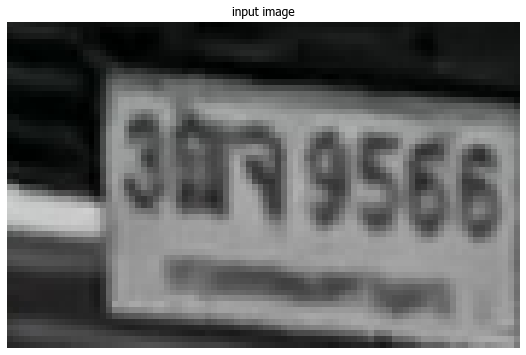

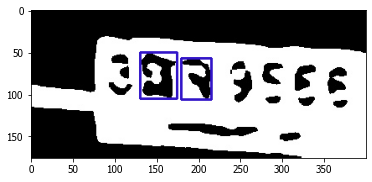

(56, 88, 3)


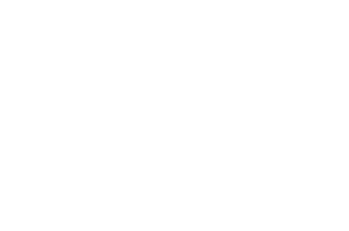

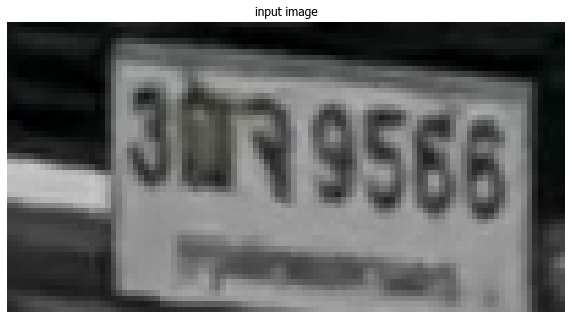

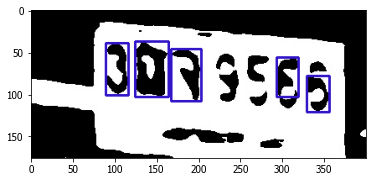

(53, 102, 3)


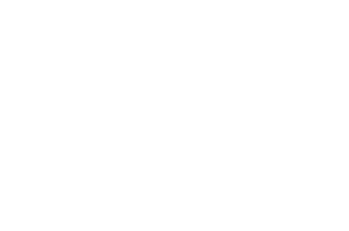

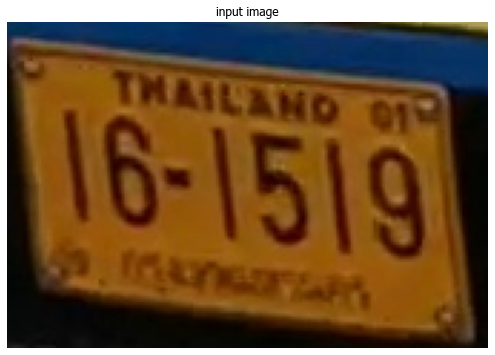

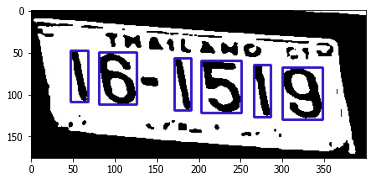

(114, 168, 3)


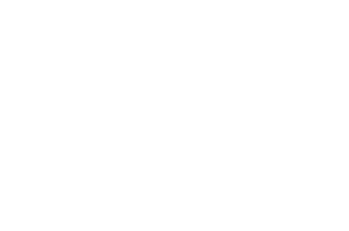

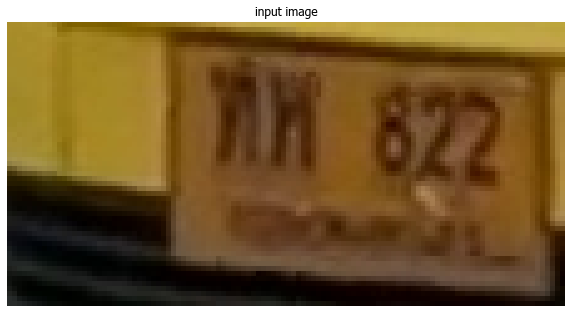

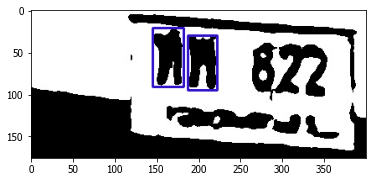

(57, 112, 3)


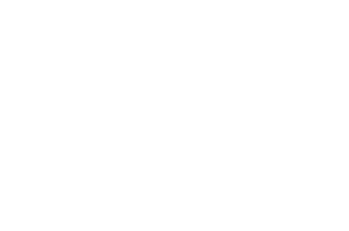

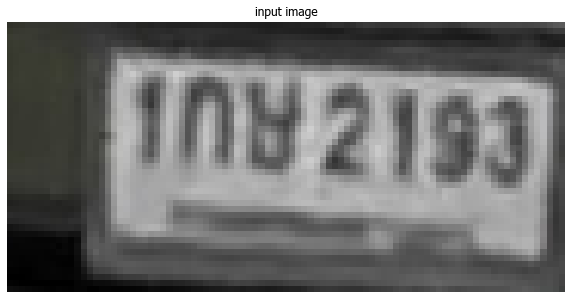

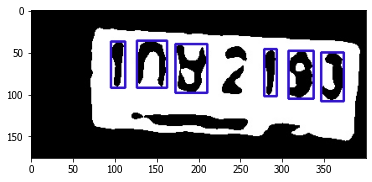

(44, 91, 3)


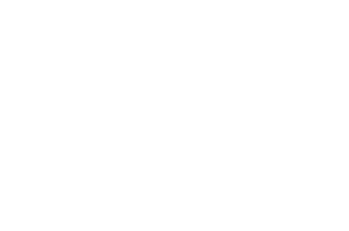

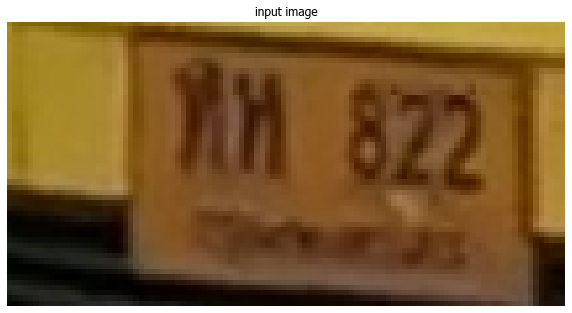

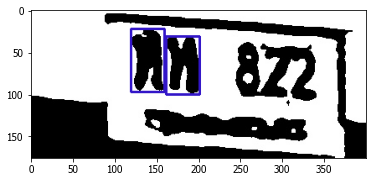

(54, 106, 3)


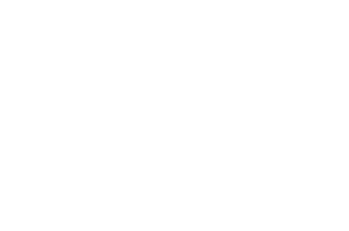

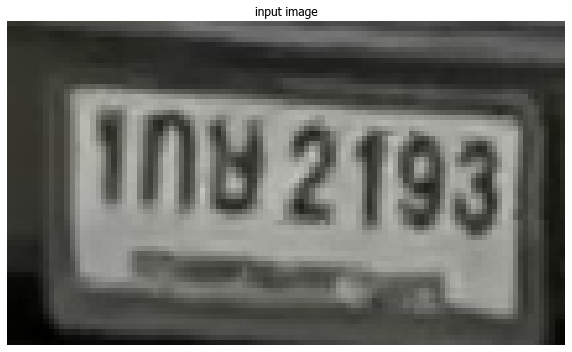

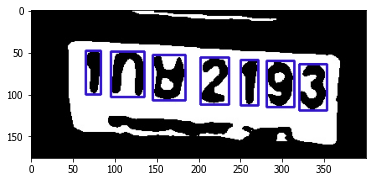

(62, 107, 3)


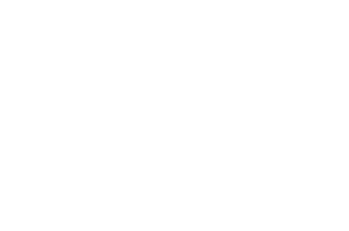

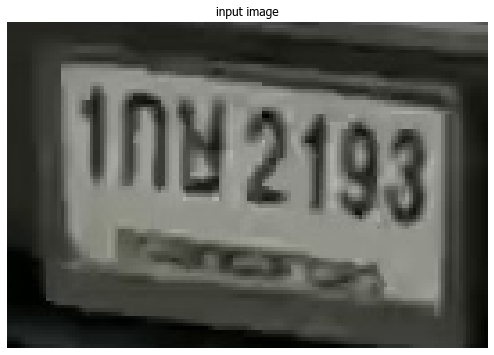

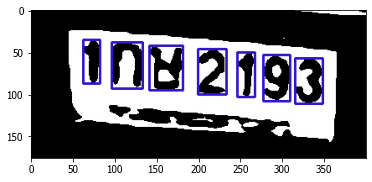

(91, 134, 3)


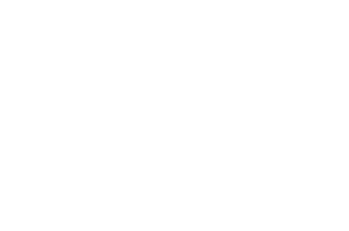

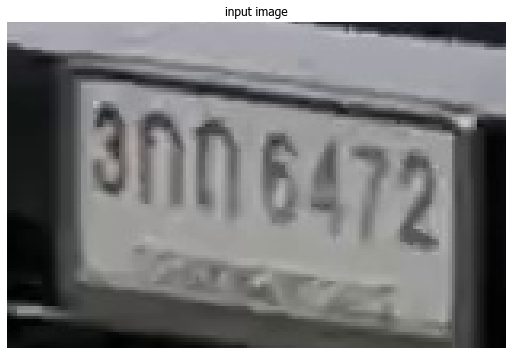

(102, 156, 3)


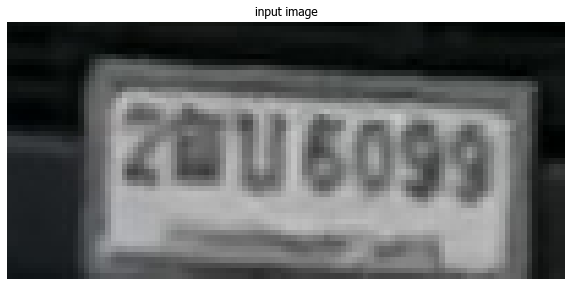

(47, 102, 3)


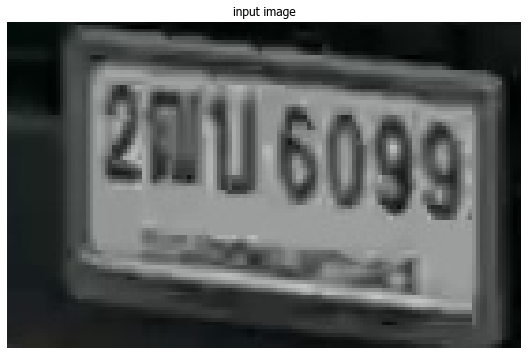

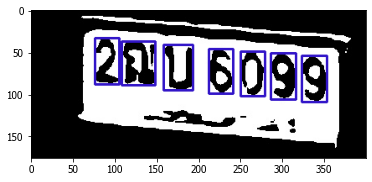

(87, 137, 3)


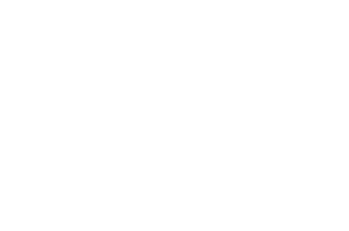

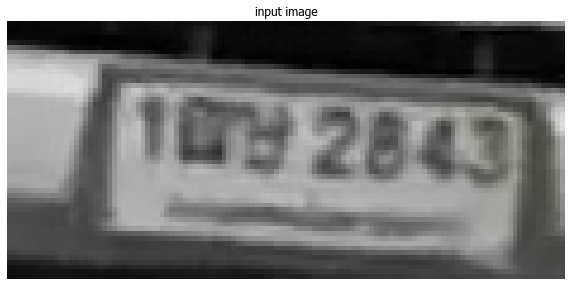

(54, 117, 3)


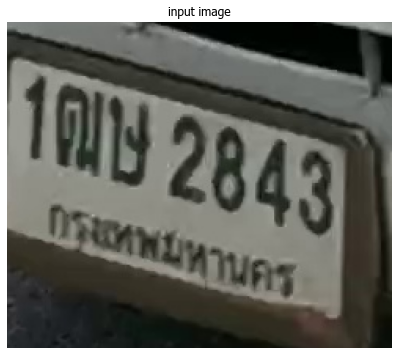

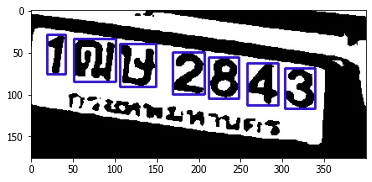

(208, 245, 3)


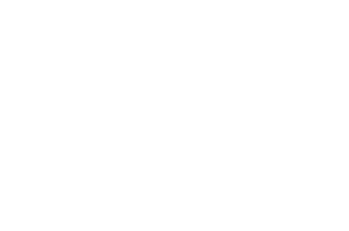

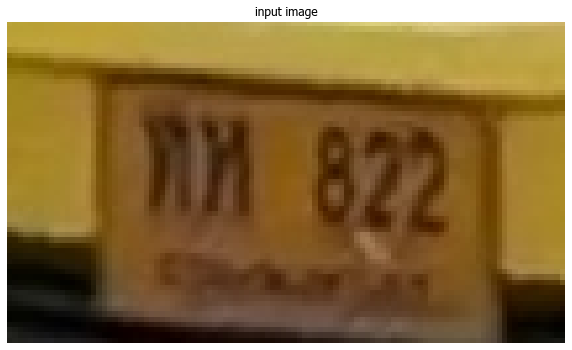

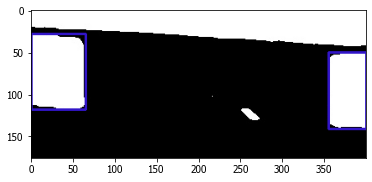

(61, 106, 3)


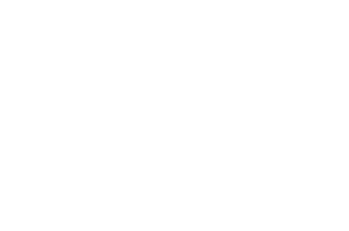

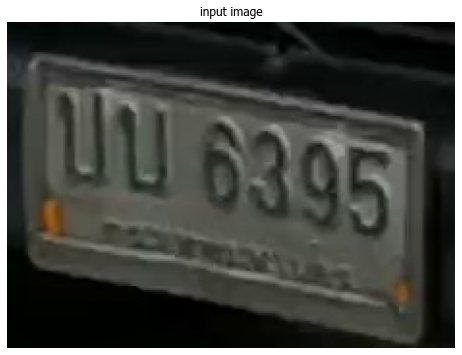

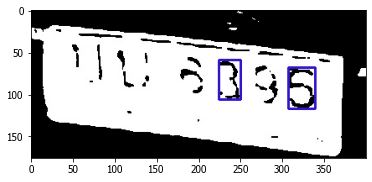

(169, 232, 3)


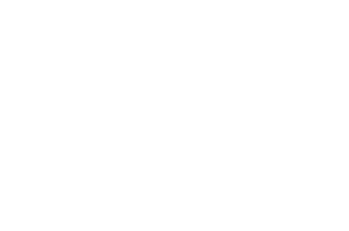

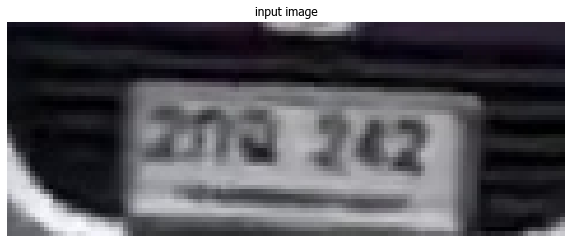

(46, 120, 3)


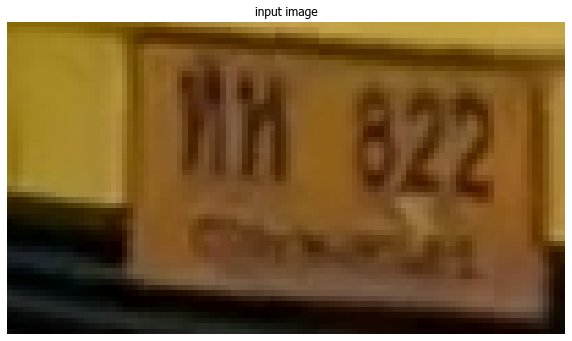

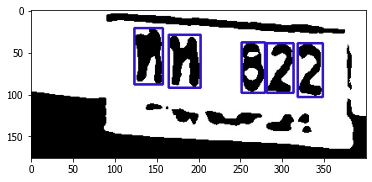

(57, 102, 3)


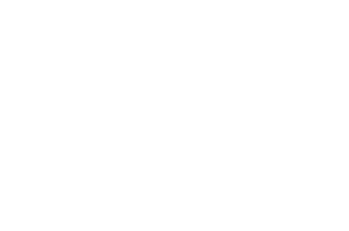

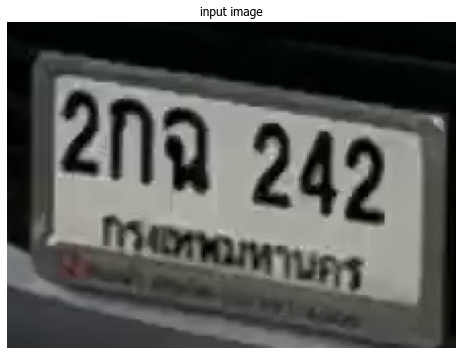

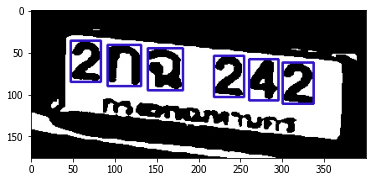

(160, 220, 3)


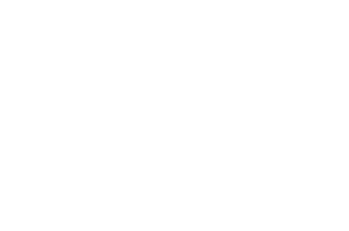

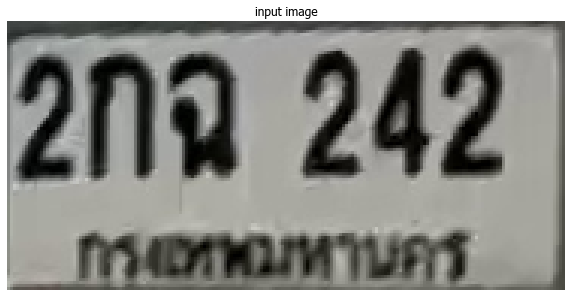

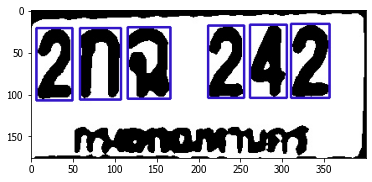

(89, 185, 3)


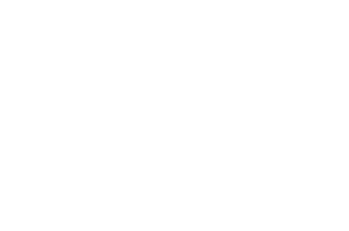

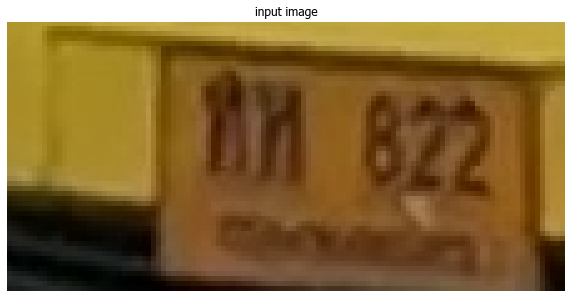

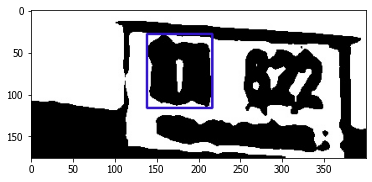

(54, 112, 3)


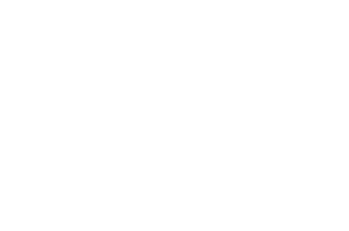

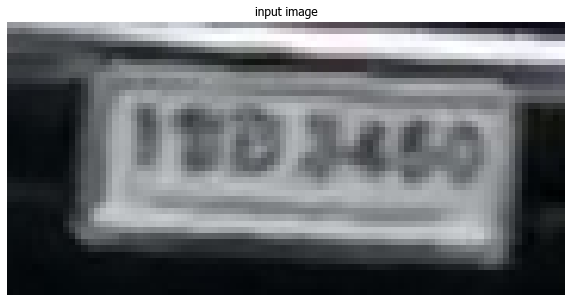

(44, 90, 3)


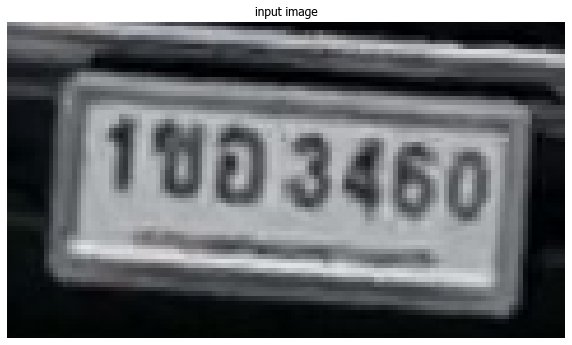

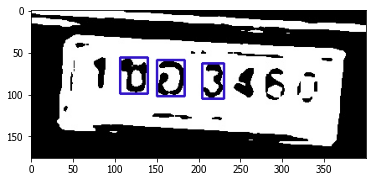

(68, 120, 3)


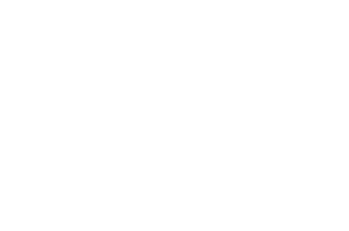

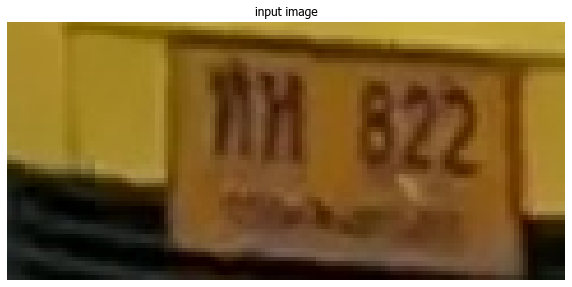

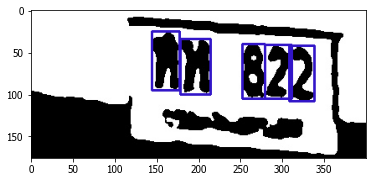

(56, 121, 3)


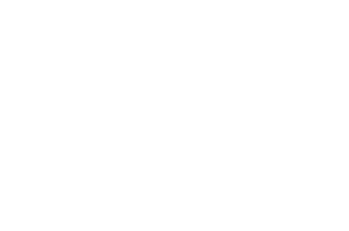

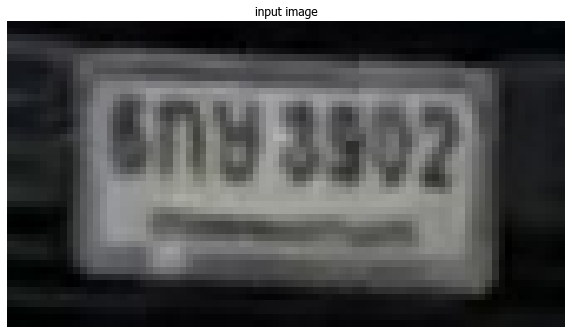

(46, 84, 3)


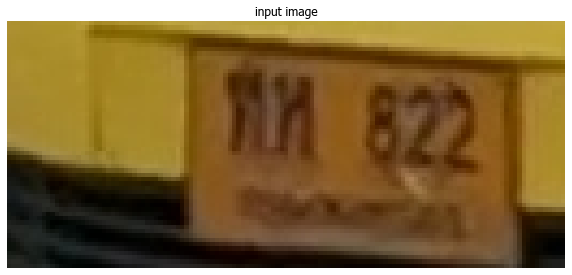

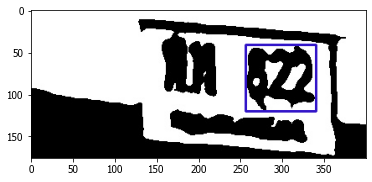

(57, 129, 3)


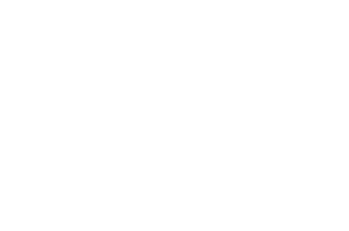

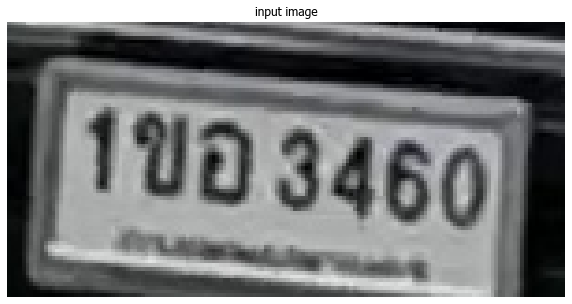

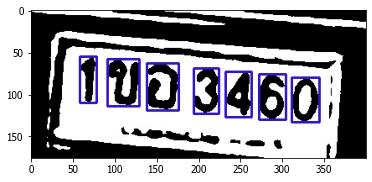

(74, 150, 3)


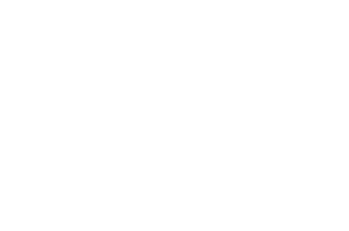

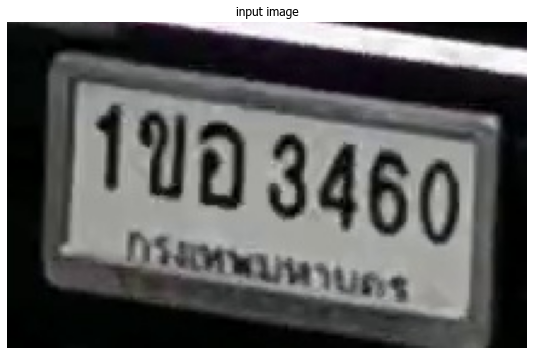

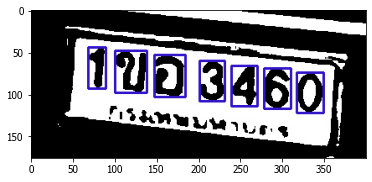

(135, 215, 3)


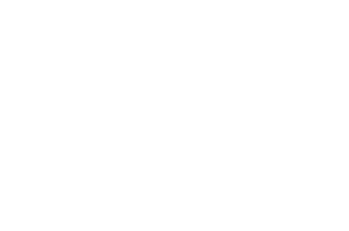

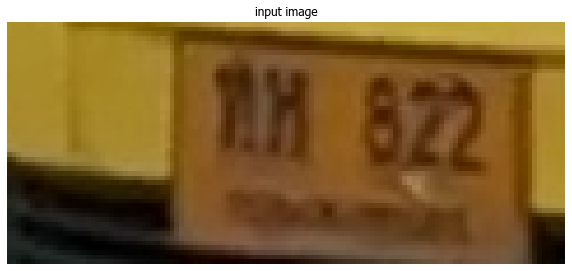

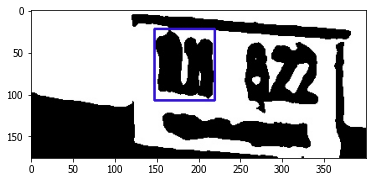

(52, 120, 3)


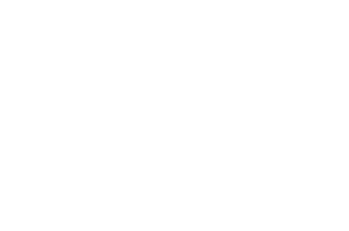

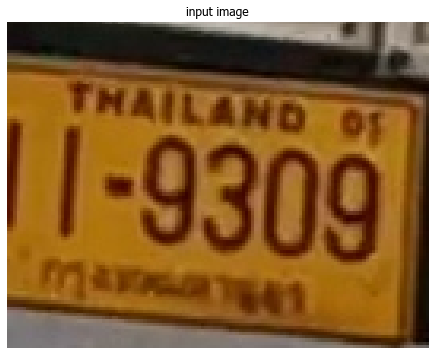

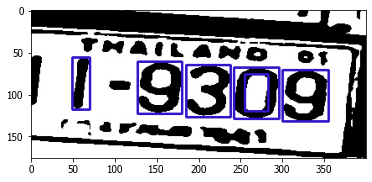

(103, 133, 3)


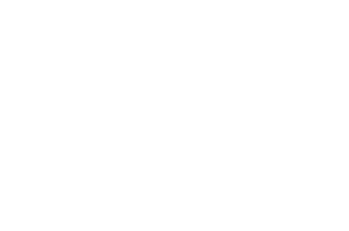

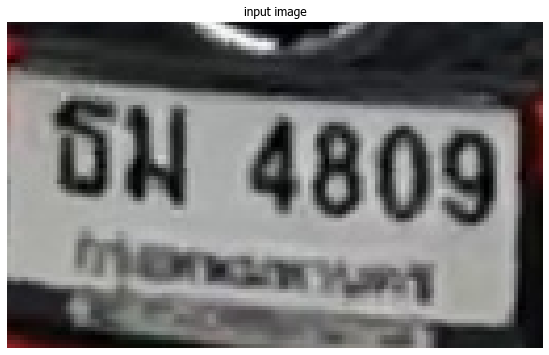

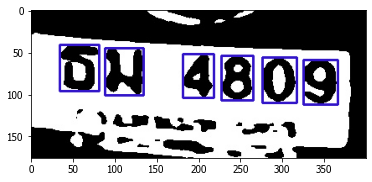

(78, 128, 3)


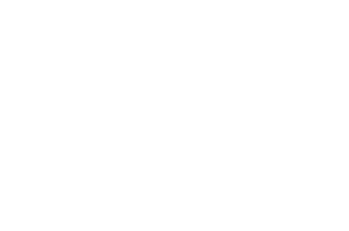

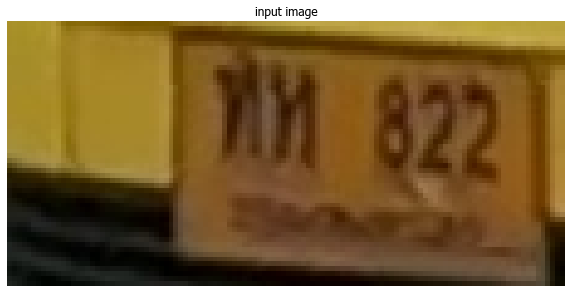

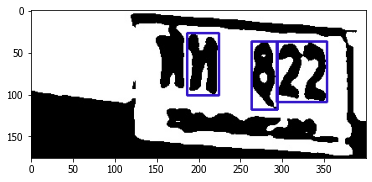

(54, 114, 3)


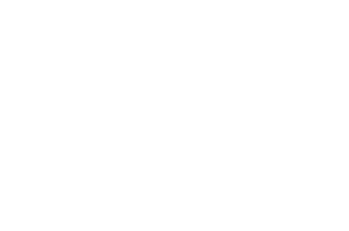

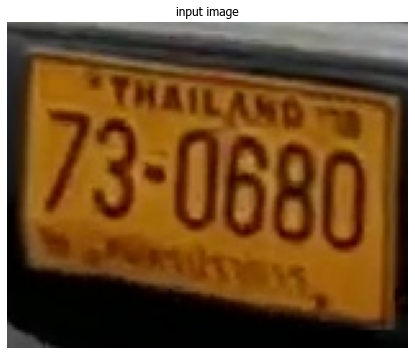

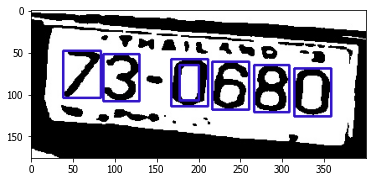

(127, 156, 3)


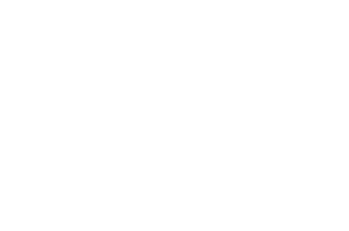

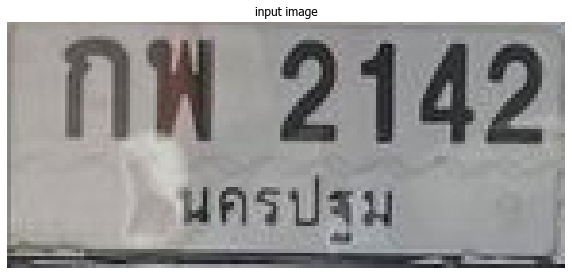

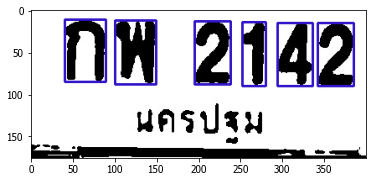

(64, 145, 3)


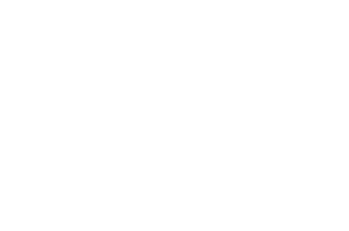

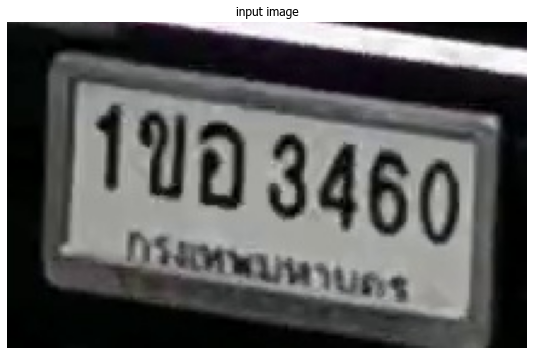

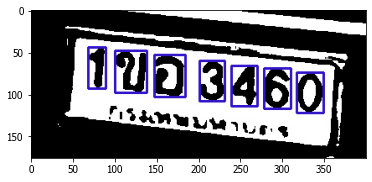

(135, 215, 3)


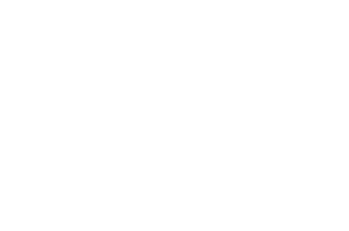

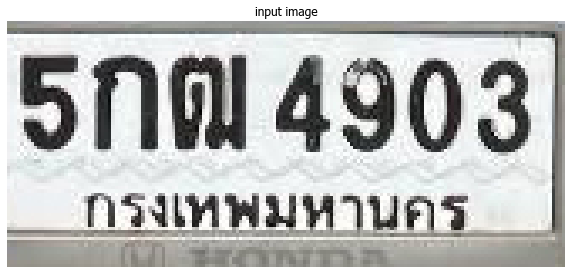

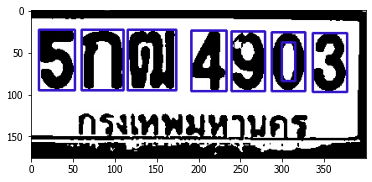

(73, 166, 3)


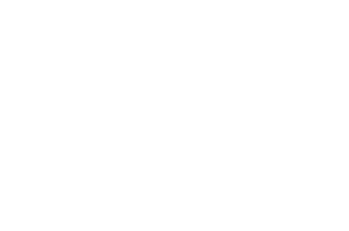

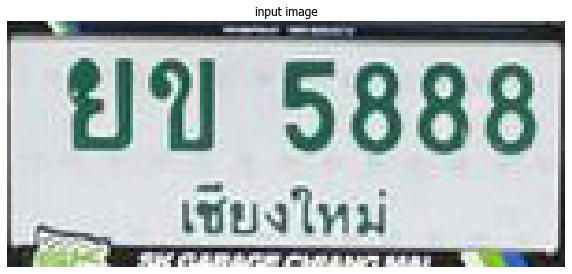

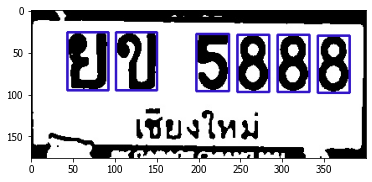

(66, 150, 3)


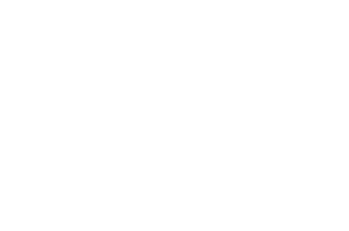

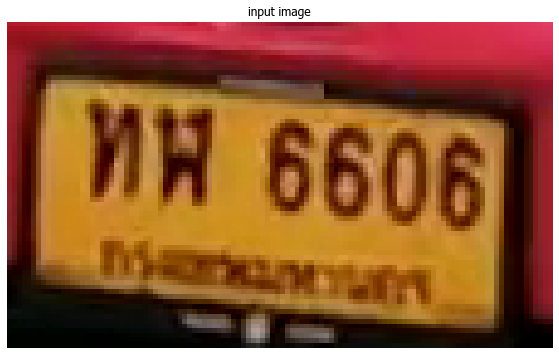

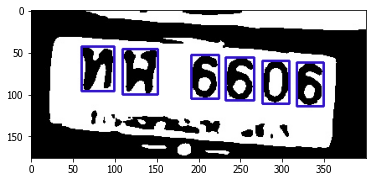

(67, 112, 3)


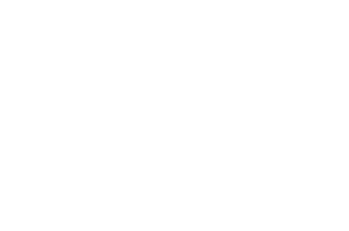

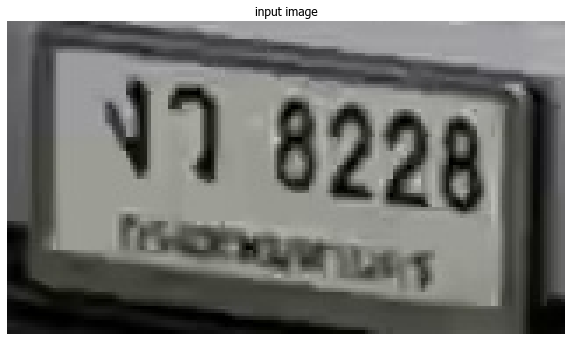

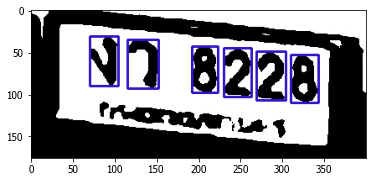

(89, 159, 3)


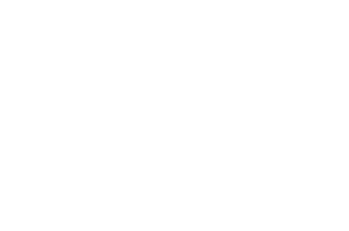

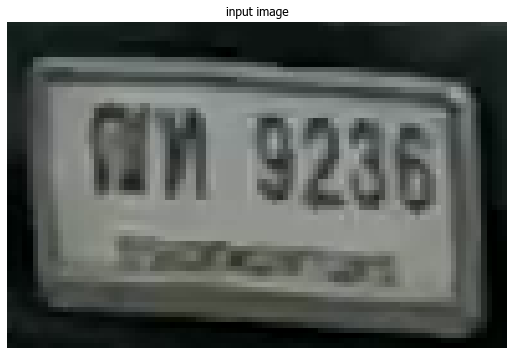

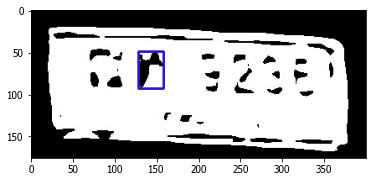

(64, 98, 3)


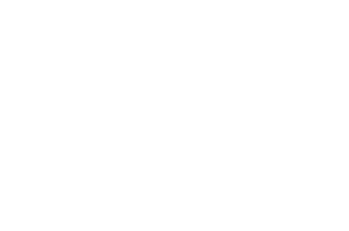

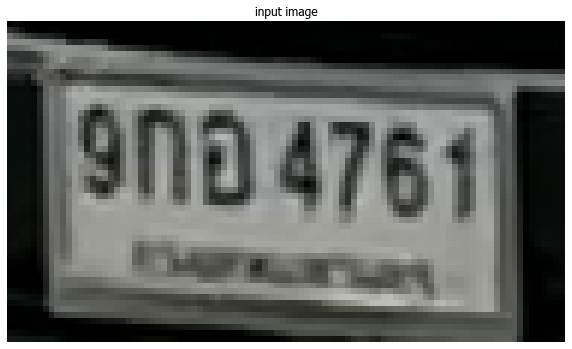

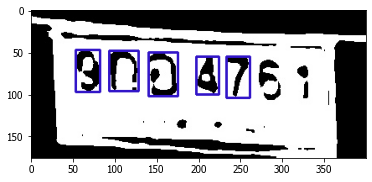

(54, 94, 3)


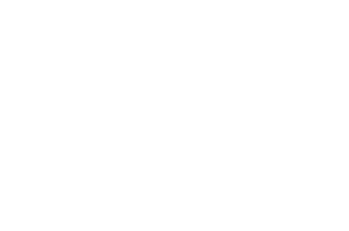

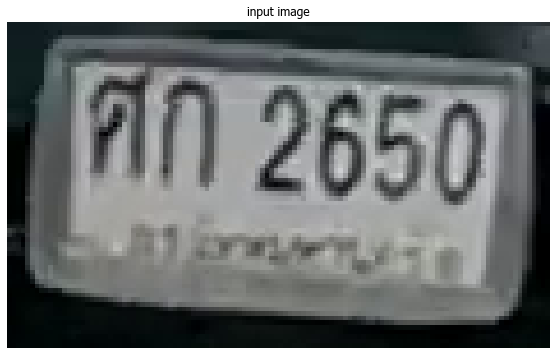

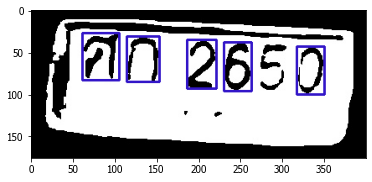

(71, 118, 3)


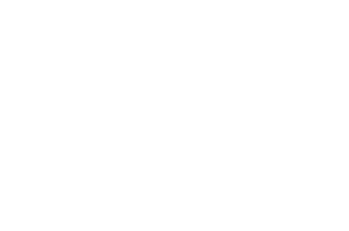

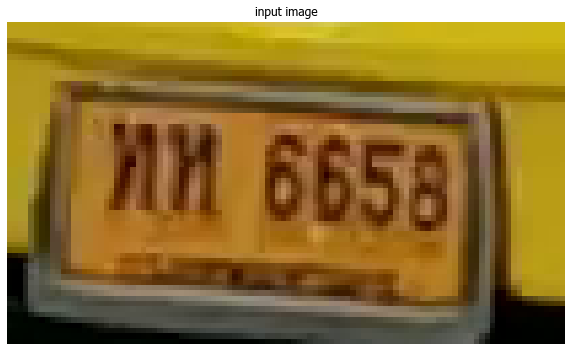

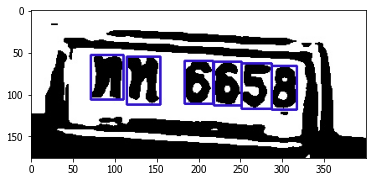

(60, 104, 3)


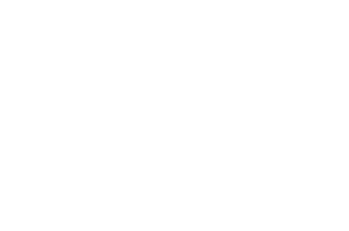

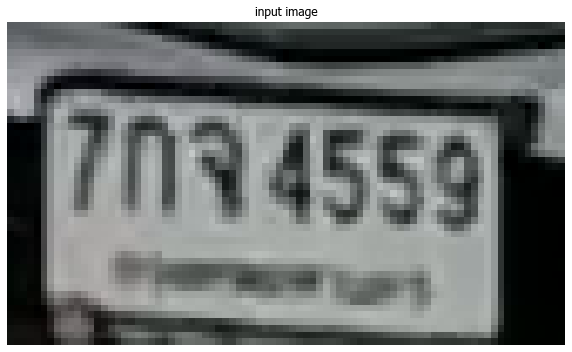

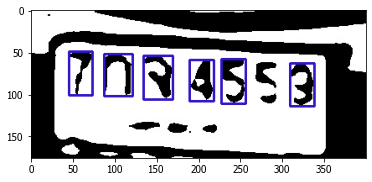

(48, 83, 3)


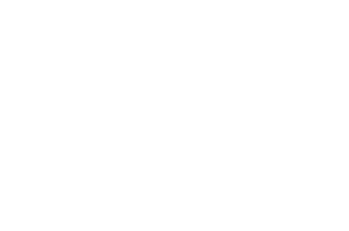

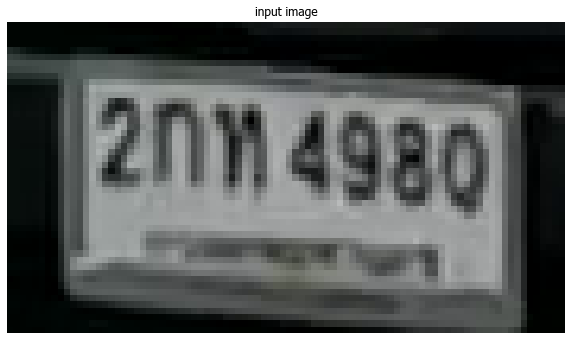

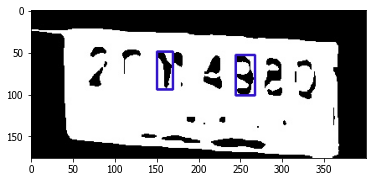

(49, 88, 3)


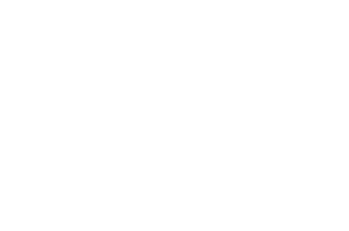

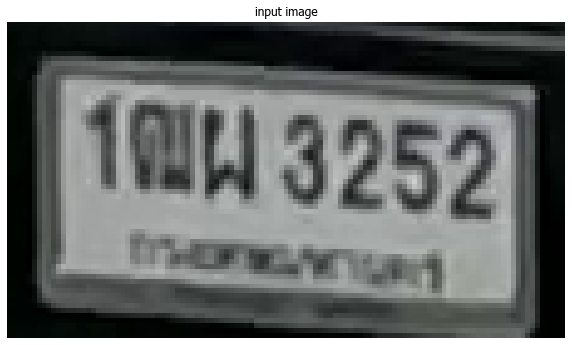

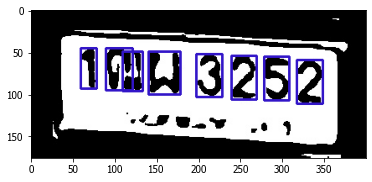

(64, 113, 3)


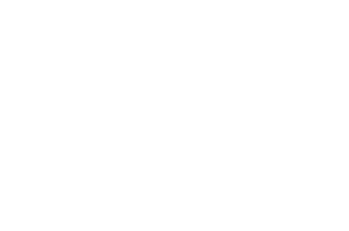

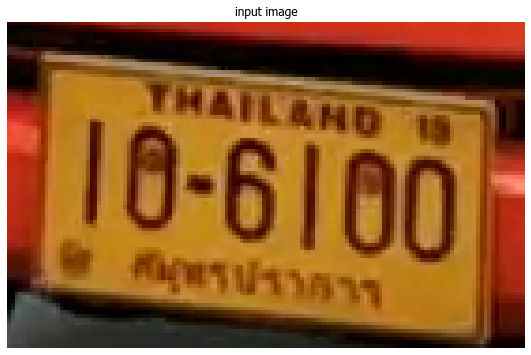

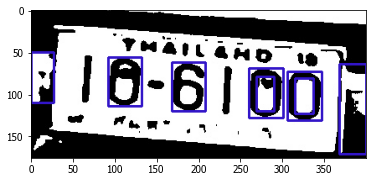

(87, 138, 3)


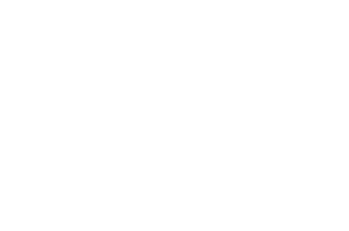

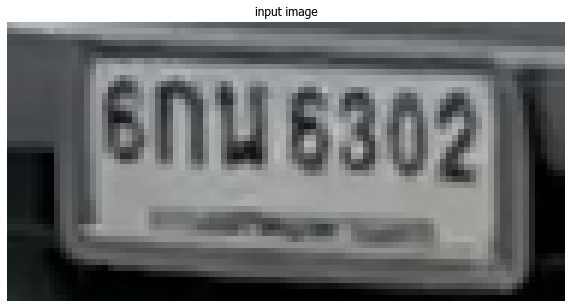

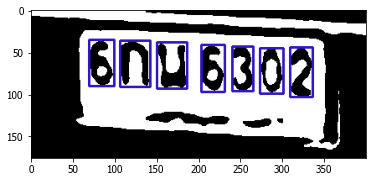

(47, 94, 3)


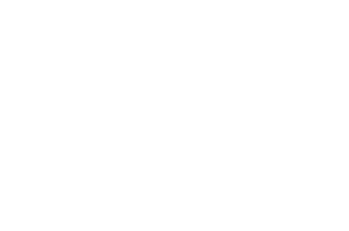

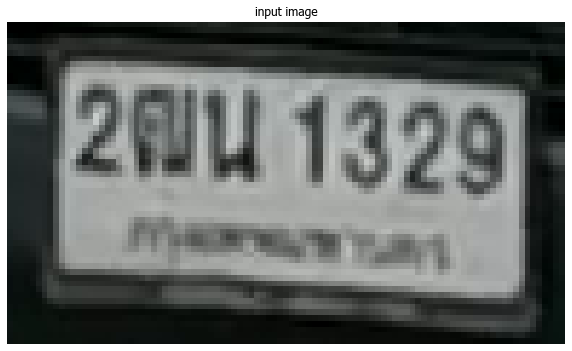

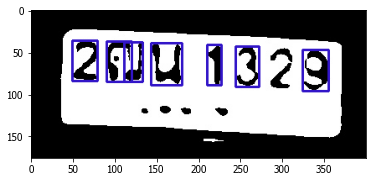

(56, 97, 3)


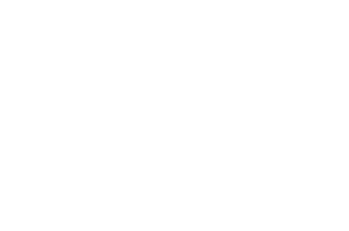

In [596]:
for i in arr:
    try:
        plate = cv2.imread('plate/'+i)
        display(plate, 'input image')
        char = segment_characters(plate)
        print(plate.shape)
        if char != []:
                n +=1
                name = "char_"+str(n)+".png"
                name_2 = "char_"+str(n)
                plt.axis('off')
#         try:
#             for i in range(10):
#                 #plt.subplot(1, 10, i+1)
#                 #plt.imshow(char[i], cmap='gray')
#                 n +=1
#                 name = "char_"+str(n)+".png"
#                 name_2 = "char_"+str(n)
#                 plt.axis('off')
#                 #plt.savefig(name)
#                 #Image.open(name).save(name_2+'jpg','JPEG')
#         except:
#             pass
    except:
        pass

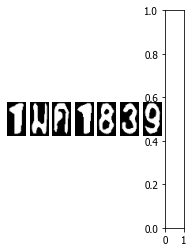

In [518]:
try:
    for i in range(15):
        plt.subplot(1, 15, i+1)
        plt.imshow(char[i], cmap='gray')
#         n +=1
#         name = "char_"+str(n)+".png"
        plt.axis('off')
#         plt.savefig(name)
except:
    pass

### Build Model for characters

In [534]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'dataset/Binary' 
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode
    ='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/test',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 4088 images belonging to 45 classes.
Found 1357 images belonging to 45 classes.


In [535]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [536]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(45, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [537]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [538]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [539]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 50, verbose=1, callbacks=callbacks)

Epoch 1/50
4088/4088 [==============================] - 153s 37ms/step - loss: 1.8059 - custom_f1score: 0.5105 - val_loss: 1.1458 - val_custom_f1score: 0.6826
Epoch 2/50
4088/4088 [==============================] - 150s 37ms/step - loss: 0.4697 - custom_f1score: 0.8625 - val_loss: 0.4683 - val_custom_f1score: 0.8740
Epoch 3/50
4088/4088 [==============================] - 140s 34ms/step - loss: 0.2981 - custom_f1score: 0.9171 - val_loss: 0.2825 - val_custom_f1score: 0.9215
Epoch 4/50
4088/4088 [==============================] - 140s 34ms/step - loss: 0.2423 - custom_f1score: 0.9286 - val_loss: 0.3257 - val_custom_f1score: 0.9201
Epoch 5/50
4088/4088 [==============================] - 141s 34ms/step - loss: 0.1907 - custom_f1score: 0.9420 - val_loss: 0.2734 - val_custom_f1score: 0.9415
Epoch 6/50
4088/4088 [==============================] - 141s 34ms/step - loss: 0.1694 - custom_f1score: 0.9518 - val_loss: 0.4995 - val_custom_f1score: 0.8572
Epoch 7/50
4088/4088 [========================

In [541]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = 'บจฉฎฮขคกฆลมงนพผรษฒทตธวยศอธฉญฐภฌฬหสณ0123456789'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1มค1839


In [567]:
model.save('LicensePlate.h5', save_format='tf')

###Run model to predict Use here

In [581]:
dependencies = {
    'custom_f1score': custom_f1score
}

model = keras.models.load_model("LicensePlate.h5",custom_objects={'custom_f1score': custom_f1score})

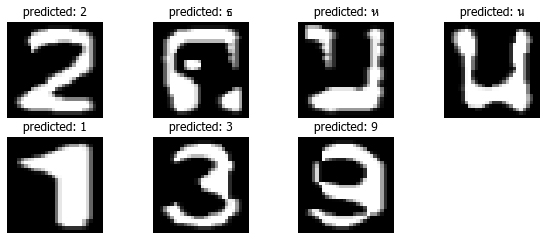

In [597]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.rc('font', family='Tahoma')
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

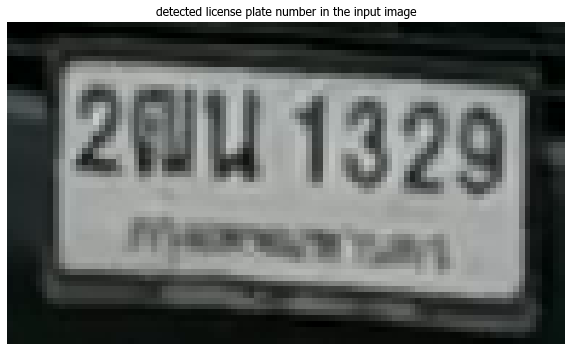

'2ธหน139'

In [598]:
plate_number = show_results()
#output_img, plate = detect_plate(img, plate_number)
display(plate, 'detected license plate number in the input image')
plate_number